In [ ]:
from google.colab import drive
drive.mount('/content/drive')


ValueError: Mountpoint must not already contain files

In [ ]:
import os
import pandas as pd

# Folder containing pre-2020 CSV files
folder_path = '/content/Pre_2020'  # <- Make sure this path is correct!

# Combine all valid CSVs
df_list = []
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(file_path)
            df['Stock'] = file.replace('.csv', '')  # Inject stock name
            df_list.append(df)
        except Exception as e:
            print(f"❌ Failed to read {file}: {e}")

# Concatenate all files into one DataFrame
df_pre = pd.concat(df_list, ignore_index=True)

# Display total records and sample
print(f"✅ Total rows combined: {len(df_pre)}")
print(df_pre.columns)
df_pre.head()


✅ Total rows combined: 25351
Index(['Year', 'Stock', 'Market Price', 'Yearly Average Price',
       'Yearly Avg Price % Increase', 'Yearly Volatility', 'Yearly Growth',
       'EPS', 'Projected EPS', 'P/E Ratio', 'Fundamental P/E', 'Book Value',
       'P/B Ratio', 'ROE', 'Start of S-Curve Price', 'S-Curve Year',
       'Years to S-Curve Start', 'Intrinsic Value', 'Intrinsic Value (Graham)',
       'Intrinsic Value (Combined)', 'Market to Intrinsic Ratio',
       'Valuation Status'],
      dtype='object')


Year                          Stock  Market Price  Yearly Average Price  \
0  2002  OSWALGREEN.NS_yearly_analysis          4.36                  5.02   
1  2003  OSWALGREEN.NS_yearly_analysis          7.43                  4.89   
2  2004  OSWALGREEN.NS_yearly_analysis          9.52                  5.10   
3  2005  OSWALGREEN.NS_yearly_analysis         34.94                 16.90   
4  2006  OSWALGREEN.NS_yearly_analysis         39.96                 33.14   

   Yearly Avg Price % Increase  Yearly Volatility  Yearly Growth   EPS  \
0                         0.00               1.19          -0.43  0.05   
1                        -2.65               1.33           0.71  0.06   
2                         4.25               1.01           0.20  0.07   
3                       231.46              10.28           2.71  0.07   
4                        96.12               7.76           0.09  0.08   

   Projected EPS  P/E Ratio  ...  P/B Ratio  ROE  Start of S-Curve Price  \
0           0.05      79.61  ...       0.25  0.0                    4.89   
1           0.07     123.50  ...       0.40  0.0                    4.89   
2           0.08     143.74  ...       0.47  0.0                    4.89   
3           0.09     479.77  ...       1.60  0.0                    4.89   
4           0.09     498.80  ...       1.70  0.0                    4.89   

   S-Curve Year  Years to S-Curve Start  Intrinsic Value  \
0        2003.0                     7.0            17.29   
1        2003.0                     7.0            18.67   
2        2003.0                     7.0            20.16   
3        2003.0                     7.0            21.78   
4        2003.0                     7.0            23.52   

   Intrinsic Value (Graham)  Intrinsic Value (Combined)  \
0                      4.61                       10.95   
1                      5.03                       11.85   
2                      5.48                       12.82   
3                      5.97                       13.88   
4                      6.51                       15.01   

   Market to Intrinsic Ratio  Valuation Status  
0                       0.40       Undervalued  
1                       0.63       Undervalued  
2                       0.74       Undervalued  
3                       2.52        Overvalued  
4                       2.66        Overvalued  

[5 rows x 22 columns]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Drop non-numeric / non-useful columns
drop_cols = ['Valuation Status', 'Stock']  # keep 'Year' for potential use
df_pre.drop(columns=[col for col in drop_cols if col in df_pre.columns], inplace=True)

# Drop rows with NaNs again after filtering
df_pre.dropna(inplace=True)

# Extract input features (X) and targets (y)
X = df_pre.drop(columns=['Start of S-Curve Price', 'Years to S-Curve Start']).values
y_price = df_pre['Start of S-Curve Price'].values
y_years = df_pre['Years to S-Curve Start'].values

# Normalize X
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)

# Normalize y_price and y_years
price_scaler = MinMaxScaler().fit(y_price.reshape(-1, 1))
y_price_scaled = price_scaler.transform(y_price.reshape(-1, 1))

years_scaler = MinMaxScaler().fit(y_years.reshape(-1, 1))
y_years_scaled = years_scaler.transform(y_years.reshape(-1, 1))

# Reshape for LSTM (samples, timesteps=1, features)
X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, yp_train, yp_test, yy_train, yy_test = train_test_split(
    X_scaled_lstm, y_price_scaled, y_years_scaled, test_size=0.2, random_state=42
)


In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("yp_train shape:", yp_train.shape)
print("yy_train shape:", yy_train.shape)


X_train shape: (16142, 1, 18)
X_test shape: (4036, 1, 18)
yp_train shape: (16142, 1)
yy_train shape: (16142, 1)


In [ ]:
print("Scaled price sample:", yp_train[:5].flatten())
print("Unscaled price sample:", price_scaler.inverse_transform(yp_train[:5]))

print("Scaled years sample:", yy_train[:5].flatten())
print("Unscaled years sample:", years_scaler.inverse_transform(yy_train[:5]))


Scaled price sample: [0.00334846 0.00191033 0.00404183 0.05466328 0.00047699]
Unscaled price sample: [[ 28.02]
 [ 15.99]
 [ 33.82]
 [457.27]
 [  4.  ]]
Scaled years sample: [0.29411765 0.05882353 0.         0.11764706 0.41176471]
Unscaled years sample: [[6.]
 [2.]
 [1.]
 [3.]
 [8.]]


In [ ]:
print("X_train[0]:", X_train[0])
print("Feature min/max after scaling:", X_scaled.min(), X_scaled.max())


X_train[0]: [[1.00000000e+00 5.24284521e-03 5.32623861e-03 4.25175046e-01
  4.11000757e-03 3.64521658e-01 5.21237018e-03 4.73071325e-03
  2.07006965e-04 8.44876331e-04 4.79586546e-03 1.17228900e-03
  2.97988577e-03 2.30769231e-01 4.79586546e-03 4.99821728e-03
  4.91437583e-03 1.48117966e-03]]
Feature min/max after scaling: 0.0 1.0000000000000002


In [ ]:
import os

save_dir = "/content/preprocessed_data"
os.makedirs(save_dir, exist_ok=True)


In [ ]:
import numpy as np

np.save(os.path.join(save_dir, "X_train.npy"), X_train)
np.save(os.path.join(save_dir, "X_test.npy"), X_test)
np.save(os.path.join(save_dir, "yp_train.npy"), yp_train)
np.save(os.path.join(save_dir, "yp_test.npy"), yp_test)
np.save(os.path.join(save_dir, "yy_train.npy"), yy_train)
np.save(os.path.join(save_dir, "yy_test.npy"), yy_test)


In [ ]:
import joblib

joblib.dump(X_scaler, os.path.join(save_dir, "X_scaler.pkl"))
joblib.dump(price_scaler, os.path.join(save_dir, "price_scaler.pkl"))
joblib.dump(years_scaler, os.path.join(save_dir, "years_scaler.pkl"))


['/content/preprocessed_data/years_scaler.pkl']

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# Shared LSTM layers
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = LSTM(32)(x)
x = Dropout(0.2)(x)

# Two output heads
price_output = Dense(1, name='price_output')(x)
year_output = Dense(1, name='year_output')(x)

# Model definition
model = Model(inputs=input_layer, outputs=[price_output, year_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'price_output': 'mse', 'year_output': 'mse'},
              metrics={'price_output': 'mae', 'year_output': 'mae'})

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     21,248 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,730 (131.76 KB)

 Trainable params: 33,730 (131.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train,
    {'price_output': yp_train, 'year_output': yy_train},
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
454/454 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0481 - price_output_loss: 0.0010 - price_output_mae: 0.0151 - year_output_loss: 0.0471 - year_output_mae: 0.1753 - val_loss: 0.0411 - val_price_output_loss: 4.2882e-04 - val_price_output_mae: 0.0122 - val_year_output_loss: 0.0405 - val_year_output_mae: 0.1673
Epoch 2/50
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0418 - price_output_loss: 9.1541e-04 - price_output_mae: 0.0127 - year_output_loss: 0.0409 - year_output_mae: 0.1692 - val_loss: 0.0400 - val_price_output_loss: 3.6471e-04 - val_price_output_mae: 0.0090 - val_year_output_loss: 0.0395 - val_year_output_mae: 0.1674
Epoch 3/50
454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0403 - price_output_loss: 9.6011e-04 - price_output_mae: 0.0114 - year_output_loss: 0.0393 - year_output_mae: 0.1658 - val_loss: 0.0395 - val_price_output_loss: 3.4041e-04 - val_price_output_mae: 0.0085 - val_year_output_loss: 0.0391 - val_year_output_mae: 0.1655
Epoch 4/50
454/454 ━━━━━━

In [ ]:
loss, price_loss, year_loss, price_mae, year_mae = model.evaluate(
    X_test,
    {'price_output': yp_test, 'year_output': yy_test}
)

print(f"Price MAE: {price_mae:.4f}, Years MAE: {year_mae:.4f}")


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0319 - price_output_loss: 6.6443e-04 - price_output_mae: 0.0093 - year_output_loss: 0.0312 - year_output_mae: 0.1465
Price MAE: 0.0085, Years MAE: 0.1472


In [ ]:
model.save("/content/preprocessed_data/lstm_dual_output_model.h5")


In [ ]:
model.save("/content/preprocessed_data/lstm_dual_output_model.keras")


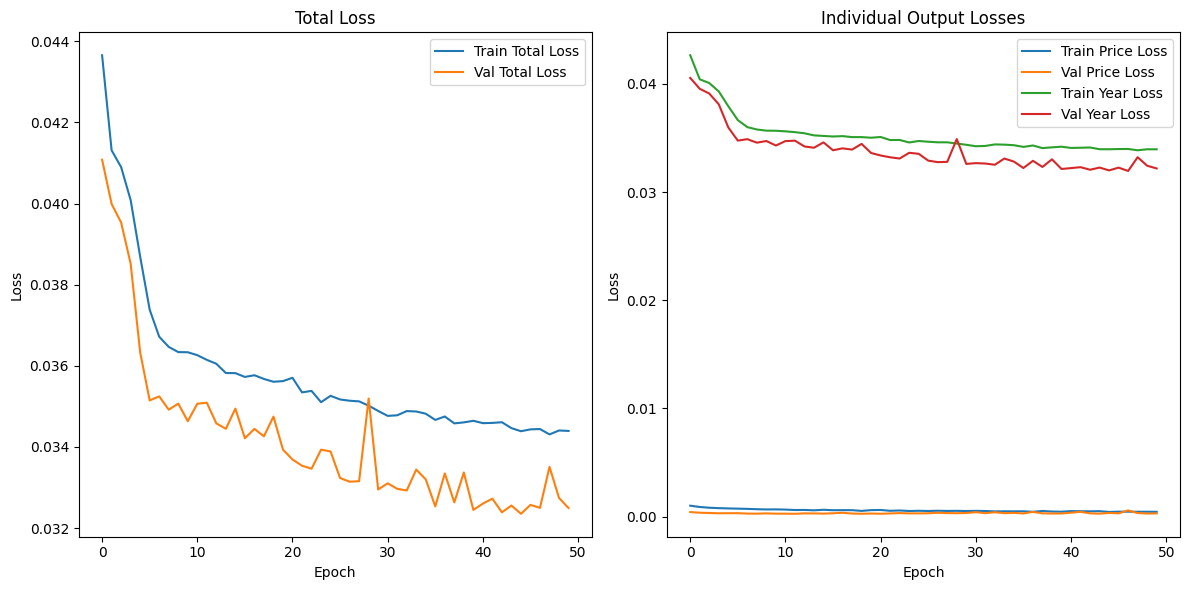

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
price_loss = history.history['price_output_loss']
val_price_loss = history.history['val_price_output_loss']
year_loss = history.history['year_output_loss']
val_year_loss = history.history['val_year_output_loss']

# Plot overall loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Total Loss')
plt.plot(val_loss, label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot each output loss
plt.subplot(1, 2, 2)
plt.plot(price_loss, label='Train Price Loss')
plt.plot(val_price_loss, label='Val Price Loss')
plt.plot(year_loss, label='Train Year Loss')
plt.plot(val_year_loss, label='Val Year Loss')
plt.title('Individual Output Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Scaler doesn't have feature names stored


In [ ]:
import os
import pandas as pd

# Set folder path to your Post-2020 CSVs
post_2020_folder = '/content/drive/MyDrive/Final Data/Post_2020/stock_analysis_data'

# List to collect DataFrames
df_post_list = []

# Loop through files in folder
for file in os.listdir(post_2020_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(post_2020_folder, file)
        try:
            df = pd.read_csv(file_path)
            df['Stock'] = file.replace('.csv', '')  # Add stock name from file
            df_post_list.append(df)
        except Exception as e:
            print(f"❌ Failed to read {file}: {e}")

# Combine all into a single DataFrame
df_post = pd.concat(df_post_list, ignore_index=True)

# Display basic info
print(f"✅ Total rows loaded: {len(df_post)}")
print(df_post.columns)
df_post.head()


✅ Total rows loaded: 2392
Index(['Year', 'Stock', 'Market Price', 'Yearly Average Price',
       'Yearly Volatility', 'Yearly Growth', 'EPS', 'Projected EPS',
       'P/E Ratio', 'Fundamental P/E', 'Book Value', 'P/B Ratio', 'ROE',
       'Intrinsic Value', 'Intrinsic Value (Graham)',
       'Intrinsic Value (Combined)', 'Market to Intrinsic Ratio',
       'Valuation Status'],
      dtype='object')


Year                         Stock  Market Price  Yearly Average Price  \
0  2022    AAATECH.NS_yearly_analysis         59.14                 61.93   
1  2023    AAATECH.NS_yearly_analysis         83.39                 59.94   
2  2024    AAATECH.NS_yearly_analysis        103.62                110.93   
3  2025    AAATECH.NS_yearly_analysis         75.97                 88.01   
4  2021  3IINFOLTD.NS_yearly_analysis         94.65                 81.96   

   Yearly Volatility  Yearly Growth     EPS  Projected EPS  P/E Ratio  \
0               7.51          -0.24    1.53           1.38      38.59   
1               8.98           0.32    1.69           2.02      49.46   
2              14.32           0.20    1.85           2.22      55.87   
3              11.54          -0.29    2.04           1.84      37.24   
4              25.91           2.05 -549.95        -659.94        NaN   

   Fundamental P/E  Book Value  P/B Ratio    ROE  Intrinsic Value  \
0            11.87       18.19       3.25   0.08            18.19   
1            11.65       19.64       4.25   0.09            19.64   
2            11.44       21.21       4.88   0.09            21.21   
3            11.23       22.91       3.32   0.09            22.91   
4            25.00       11.95       7.92 -46.01        -13748.72   

   Intrinsic Value (Graham)  Intrinsic Value (Combined)  \
0                     25.04                       21.62   
1                     27.30                       23.47   
2                     29.75                       25.48   
3                     32.43                       27.67   
4                       NaN                   -13748.72   

   Market to Intrinsic Ratio Valuation Status  
0                       2.74       Overvalued  
1                       3.55       Overvalued  
2                       4.07       Overvalued  
3                       2.75       Overvalued  
4                        NaN       Fair Value

In [ ]:
# Make a copy to keep original safe
df_post_clean = df_post.copy()

# Drop non-numeric / non-useful columns
drop_cols = ['Valuation Status', 'Stock', 'Start of S-Curve Price', 'Years to S-Curve Start']
df_post_clean.drop(columns=[col for col in drop_cols if col in df_post_clean.columns], inplace=True)

# Drop rows with missing values
df_post_clean.dropna(inplace=True)

print("✅ Cleaned post-2020 data shape:", df_post_clean.shape)


✅ Cleaned post-2020 data shape: (2052, 16)


In [ ]:
# Apply the same MinMaxScaler used during training
X_post_scaled = X_scaler.transform(df_post_clean.values)

# Reshape for LSTM input: (samples, timesteps=1, features)
X_post_scaled_lstm = X_post_scaled.reshape((X_post_scaled.shape[0], 1, X_post_scaled.shape[1]))


In [ ]:
df_post_clean.to_csv('/content/drive/MyDrive/Final Data/Post_2020/preprocessed_data/preprocessed_post2020_data.csv', index=False)
print("📁 Saved cleaned & preprocessed post-2020 data.")


📁 Saved cleaned & preprocessed post-2020 data.


In [ ]:
from tensorflow.keras.models import load_model

# Load model from .keras file
model = load_model('/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data/lstm_dual_output_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Predict using the trained model
predictions = model.predict(X_post_scaled_lstm)

# ❌ Wrong: This assumes a single array with two columns
# pred_price_scaled = predictions[:, 0].reshape(-1, 1)
# pred_years_scaled = predictions[:, 1].reshape(-1, 1)

# ✅ Correct: Unpack the two outputs
pred_price_scaled, pred_years_scaled = predictions

# Inverse transform to get real values
pred_price = price_scaler.inverse_transform(pred_price_scaled).flatten()
pred_years = years_scaler.inverse_transform(pred_years_scaled).flatten()


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
print(type(predictions), len(predictions))
print(type(predictions[0]), predictions[0].shape)
print(type(predictions[1]), predictions[1].shape)


<class 'list'> 2
<class 'numpy.ndarray'> (2052, 1)
<class 'numpy.ndarray'> (2052, 1)


In [ ]:
df_post_combined_filtered = df_post_combined.drop(columns=drop_cols, errors='ignore').dropna()

# Add predictions to the filtered version
df_post_combined_filtered['Predicted Start of S-Curve Price'] = pred_price
df_post_combined_filtered['Predicted Years to S-Curve Start'] = pred_years


In [ ]:
print(df_post_combined_filtered.columns.tolist())


['Year', 'Market Price', 'Yearly Average Price', 'Yearly Volatility', 'Yearly Growth', 'EPS', 'Projected EPS', 'P/E Ratio', 'Fundamental P/E', 'Book Value', 'P/B Ratio', 'ROE', 'Intrinsic Value', 'Intrinsic Value (Graham)', 'Intrinsic Value (Combined)', 'Market to Intrinsic Ratio', 'Predicted Start of S-Curve Price', 'Predicted Years to S-Curve Start']


In [ ]:
import os
import glob
import pandas as pd

# Define folder path
post_2020_folder = '/content/drive/MyDrive/Final Data/Post_2020/Processed'

# Get list of CSVs
post_2020_files = glob.glob(os.path.join(post_2020_folder, "*.csv"))

# Read and tag each stock
dfs_post = []
for file in post_2020_files:
    stock_name = os.path.basename(file).replace(".csv", "")
    df = pd.read_csv(file)
    df['Stock'] = stock_name  # ✅ Add stock name column
    dfs_post.append(df)

# Combine all
df_post_combined = pd.concat(dfs_post, ignore_index=True)
print("✅ Reloaded with Stock column. Shape:", df_post_combined.shape)


✅ Reloaded with Stock column. Shape: (2392, 17)


In [ ]:
output_folder = '/content/drive/MyDrive/Final Data/Post_2020/Predicted'
os.makedirs(output_folder, exist_ok=True)

for stock, df_stock in df_post_combined_filtered.groupby('Stock'):
    file_name = f"{stock}_predictions.csv"
    save_path = os.path.join(output_folder, file_name)
    df_stock.to_csv(save_path, index=False)
    print(f"✅ Saved: {file_name}")


KeyError: 'Stock'

In [ ]:
import os
import pandas as pd

# Define folder paths
post_2020_folder = '/content/drive/MyDrive/Final Data/Post_2020/Processed'
output_folder = '/content/drive/MyDrive/Final Data/Post_2020/Predicted'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Path to the single processed CSV file
processed_csv_file = os.path.join(post_2020_folder, "your_single_file.csv")  # Change 'your_single_file.csv' to the actual file name

# Read the CSV file
df_post_combined = pd.read_csv(processed_csv_file)
print(f"✅ Loaded data. Shape: {df_post_combined.shape}")

# Apply predictions to the loaded data (assuming you've already predicted and stored in 'pred_price' and 'pred_years')
# This could be your previous predictions, like pred_price, pred_years, etc.

# Add predictions to the DataFrame (example using pred_price, pred_years)
df_post_combined['Predicted Start of S-Curve Price'] = pred_price
df_post_combined['Predicted Years to S-Curve Start'] = pred_years

# Group by 'Stock' column and save separate CSVs for each stock
for stock_name, df_stock in df_post_combined.groupby('Stock'):
    # Define the output file path
    output_file = os.path.join(output_folder, f"{stock_name}_predictions.csv")

    # Save the stock-specific predictions to a new CSV file
    df_stock.to_csv(output_file, index=False)
    print(f"✅ Saved predictions for {stock_name} to: {output_file}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final Data/Post_2020/Processed/your_single_file.csv'

In [ ]:
import os
import glob
import pandas as pd

# Define folder path
post_2020_folder = '/content/drive/MyDrive/Final Data/Post_2020/Processed'

# Get list of CSVs
post_2020_files = glob.glob(os.path.join(post_2020_folder, "*.csv"))

# Read and tag each stock
dfs_post = []
for file in post_2020_files:
    stock_name = os.path.basename(file).replace(".csv", "")
    df = pd.read_csv(file)
    df['Stock'] = stock_name  # ✅ Add stock name column
    dfs_post.append(df)

# Combine all
df_post_combined = pd.concat(dfs_post, ignore_index=True)
print("✅ Reloaded with Stock column. Shape:", df_post_combined.shape)

# Preserve the 'Stock' column when creating df_post_combined_filtered
drop_cols = ['Valuation Status', 'Start of S-Curve Price', 'Years to S-Curve Start'] # Remove 'Stock' from drop_cols
df_post_combined_filtered = df_post_combined.drop(columns=drop_cols, errors='ignore').dropna()

# Add predictions to the filtered version
df_post_combined_filtered['Predicted Start of S-Curve Price'] = pred_price
df_post_combined_filtered['Predicted Years to S-Curve Start'] = pred_years

output_folder = '/content/drive/MyDrive/Final Data/Post_2020/Predicted'
os.makedirs(output_folder, exist_ok=True)

for stock, df_stock in df_post_combined_filtered.groupby('Stock'):
    file_name = f"{stock}_predictions.csv"
    save_path = os.path.join(output_folder, file_name)
    df_stock.to_csv(save_path, index=False)
    print(f"✅ Saved: {file_name}")

✅ Reloaded with Stock column. Shape: (2392, 17)
✅ Saved: AAATECH.NS_yearly_analysis_predictions.csv
✅ Saved: AADHARHFC.NS_yearly_analysis_predictions.csv
✅ Saved: AAKASH.NS_yearly_analysis_predictions.csv
✅ Saved: AAREYDRUGS.NS_yearly_analysis_predictions.csv
✅ Saved: AARON.NS_yearly_analysis_predictions.csv
✅ Saved: AARTECH.NS_yearly_analysis_predictions.csv
✅ Saved: AARTIPHARM.NS_yearly_analysis_predictions.csv
✅ Saved: AARTISURF.NS_yearly_analysis_predictions.csv
✅ Saved: AARVI.NS_yearly_analysis_predictions.csv
✅ Saved: ABDL.NS_yearly_analysis_predictions.csv
✅ Saved: ABINFRA.NS_yearly_analysis_predictions.csv
✅ Saved: ABMINTLLTD.NS_yearly_analysis_predictions.csv
✅ Saved: ABSLAMC.NS_yearly_analysis_predictions.csv
✅ Saved: ACCURACY.NS_yearly_analysis_predictions.csv
✅ Saved: ACEINTEG.NS_yearly_analysis_predictions.csv
✅ Saved: ACI.NS_yearly_analysis_predictions.csv
✅ Saved: ADL.NS_yearly_analysis_predictions.csv
✅ Saved: AEROFLEX.NS_yearly_analysis_predictions.csv
✅ Saved: AETHER.

In [ ]:
import os
import glob
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# ... (your existing code to load data and make predictions) ...

# Load the saved scalers
price_scaler = joblib.load('/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data/price_scaler.pkl')
years_scaler = joblib.load('/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data/years_scaler.pkl')

# Rescale the predicted values before adding to DataFrame
pred_price_original = price_scaler.inverse_transform(pred_price_scaled).flatten()
pred_years_original = years_scaler.inverse_transform(pred_years_scaled).flatten()

# Add rescaled predictions to the filtered version
df_post_combined_filtered['Predicted Start of S-Curve Price'] = pred_price_original
df_post_combined_filtered['Predicted Years to S-Curve Start'] = pred_years_original

output_folder = '/content/drive/MyDrive/Final Data/Post_2020/Predicted'
os.makedirs(output_folder, exist_ok=True)

for stock, df_stock in df_post_combined_filtered.groupby('Stock'):
    file_name = f"{stock}_predictions.csv"
    save_path = os.path.join(output_folder, file_name)
    df_stock.to_csv(save_path, index=False)
    print(f"✅ Saved: {file_name}")

✅ Saved: AAATECH.NS_yearly_analysis_predictions.csv
✅ Saved: AADHARHFC.NS_yearly_analysis_predictions.csv
✅ Saved: AAKASH.NS_yearly_analysis_predictions.csv
✅ Saved: AAREYDRUGS.NS_yearly_analysis_predictions.csv
✅ Saved: AARON.NS_yearly_analysis_predictions.csv
✅ Saved: AARTECH.NS_yearly_analysis_predictions.csv
✅ Saved: AARTIPHARM.NS_yearly_analysis_predictions.csv
✅ Saved: AARTISURF.NS_yearly_analysis_predictions.csv
✅ Saved: AARVI.NS_yearly_analysis_predictions.csv
✅ Saved: ABDL.NS_yearly_analysis_predictions.csv
✅ Saved: ABINFRA.NS_yearly_analysis_predictions.csv
✅ Saved: ABMINTLLTD.NS_yearly_analysis_predictions.csv
✅ Saved: ABSLAMC.NS_yearly_analysis_predictions.csv
✅ Saved: ACCURACY.NS_yearly_analysis_predictions.csv
✅ Saved: ACEINTEG.NS_yearly_analysis_predictions.csv
✅ Saved: ACI.NS_yearly_analysis_predictions.csv
✅ Saved: ADL.NS_yearly_analysis_predictions.csv
✅ Saved: AEROFLEX.NS_yearly_analysis_predictions.csv
✅ Saved: AETHER.NS_yearly_analysis_predictions.csv
✅ Saved: AFCO

Mounted at /content/drive
✅ Total rows combined: 25351
Index(['Year', 'Stock', 'Market Price', 'Yearly Average Price',
       'Yearly Volatility', 'Yearly Growth', 'EPS', 'Projected EPS',
       'P/E Ratio', 'Fundamental P/E', 'Book Value', 'P/B Ratio', 'ROE',
       'Start of S-Curve Price', 'Years to S-Curve Start', 'Intrinsic Value',
       'Intrinsic Value (Graham)', 'Intrinsic Value (Combined)',
       'Market to Intrinsic Ratio', 'Valuation Status'],
      dtype='object')
X_train shape: (16427, 1, 16)
X_test shape: (4107, 1, 16)
yp_train shape: (16427, 1)
yy_train shape: (16427, 1)
Scaled price sample: [0.00076747 0.00040525 0.00258096 0.0081828  0.00152658]
Unscaled price sample: [[ 6.35]
 [ 3.32]
 [21.52]
 [68.38]
 [12.7 ]]
Scaled years sample: [0.06896552 0.03448276 0.5862069  0.34482759 0.        ]
Unscaled years sample: [[ 3.]
 [ 2.]
 [18.]
 [11.]
 [ 1.]]
X_train[0]: [[8.62068966e-01 1.35266141e-04 1.00372886e-04 4.02352067e-04
  3.73402929e-01 1.91346303e-04 2.29575139e-04 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     20,736 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,218 (129.76 KB)

 Trainable params: 33,218 (129.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0272 - price_output_loss: 5.8377e-04 - price_output_mae: 0.0119 - year_output_loss: 0.0266 - year_output_mae: 0.1187 - val_loss: 0.0245 - val_price_output_loss: 9.1749e-04 - val_price_output_mae: 0.0091 - val_year_output_loss: 0.0234 - val_year_output_mae: 0.1106
Epoch 2/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0247 - price_output_loss: 4.7455e-04 - price_output_mae: 0.0094 - year_output_loss: 0.0242 - year_output_mae: 0.1135 - val_loss: 0.0236 - val_price_output_loss: 8.8396e-04 - val_price_output_mae: 0.0083 - val_year_output_loss: 0.0226 - val_year_output_mae: 0.1103
Epoch 3/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0233 - price_output_loss: 4.8512e-04 - price_output_mae: 0.0084 - year_output_loss: 0.0229 - year_output_mae: 0.1119 - val_loss: 0.0233 - val_price_output_loss: 8.5170e-04 - val_price_output_mae: 0.0103 - val_year_output_loss: 0.0223 - val_year_output_mae: 0.1106
Epoch 4/50
462/462 ━━━

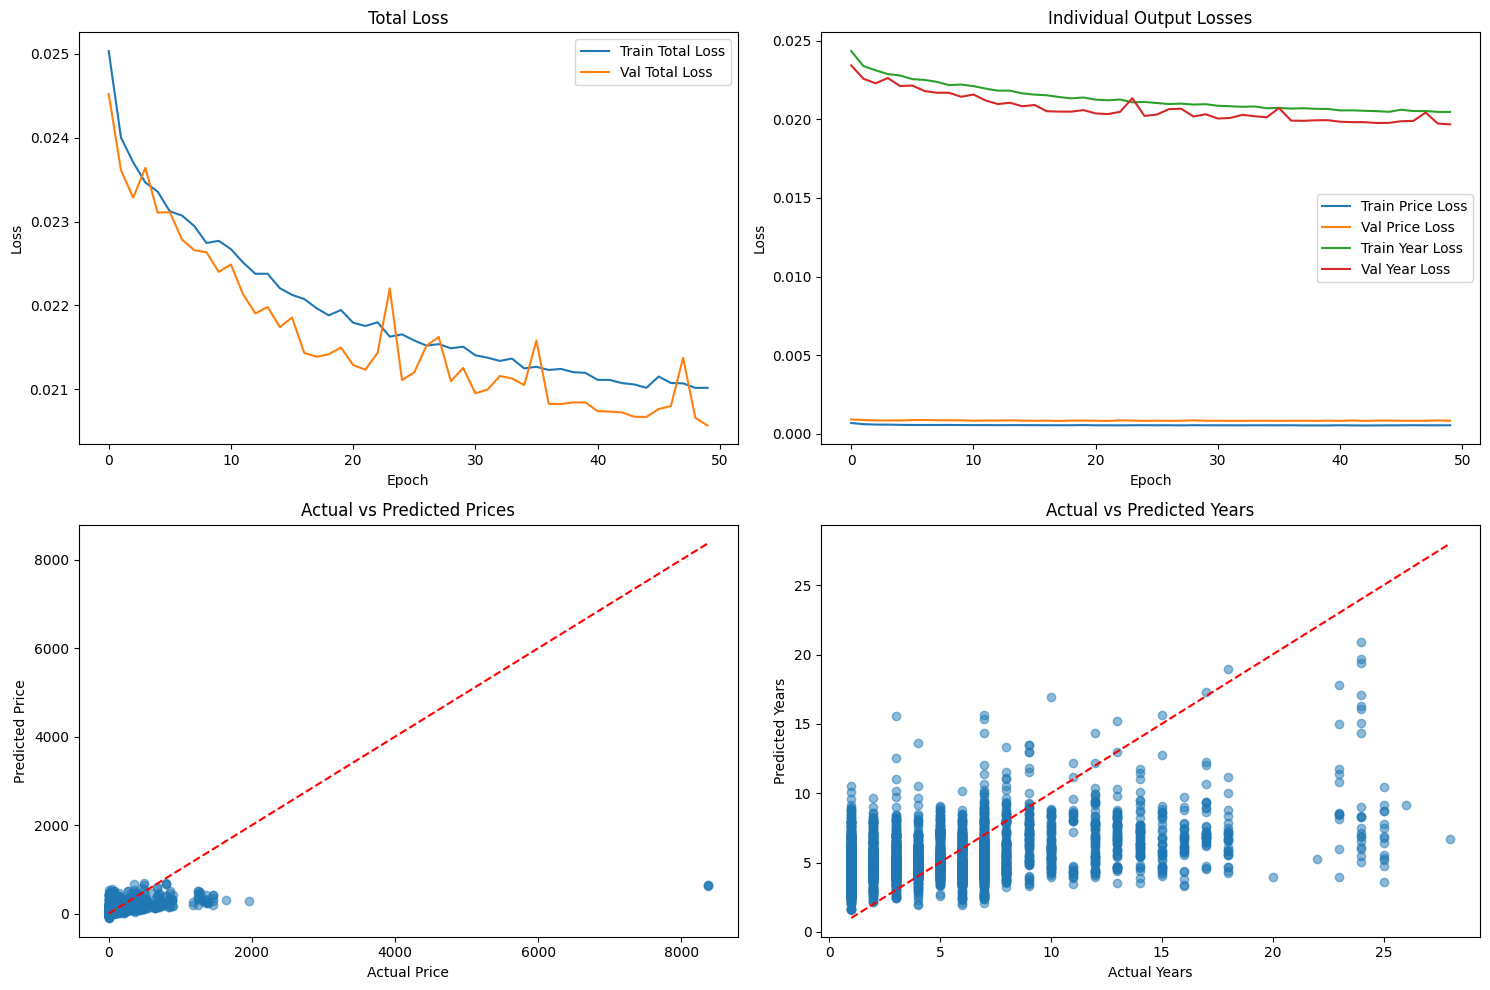

'\n# Assuming new_stock_data is a DataFrame with the same features as training data\nnew_stock_data = pd.DataFrame({\n    # Fill with your feature columns\n    # Make sure to match the original training features\n})\n\n# Remove target columns if they exist\nfeatures_only = new_stock_data.drop(columns=[\'Start of S-Curve Price\', \'Years to S-Curve Start\'], errors=\'ignore\')\n\n# Make prediction\npredicted_prices, predicted_years = predict_values(\n    features_only.values, \n    model, \n    X_scaler, \n    price_scaler, \n    years_scaler\n)\n\nprint("Predictions for new data:")\nfor i in range(len(predicted_prices)):\n    print(f"Row {i}: Predicted Price: ${predicted_prices[i][0]:.2f}, Predicted Years: {predicted_years[i][0]:.2f}")\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

# Folder containing pre-2020 CSV files
folder_path = '/content/drive/MyDrive/Final Data/Pre_2020/stock_analysis_data'  # <- Make sure this path is correct!

# Combine all valid CSVs
df_list = []
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(file_path)
            df['Stock'] = file.replace('.csv', '')  # Inject stock name
            df_list.append(df)
        except Exception as e:
            print(f"❌ Failed to read {file}: {e}")

# Concatenate all files into one DataFrame
df_pre = pd.concat(df_list, ignore_index=True)

# Display total records and sample
print(f"✅ Total rows combined: {len(df_pre)}")
print(df_pre.columns)
df_pre.head()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Drop non-numeric / non-useful columns
drop_cols = ['Valuation Status', 'Stock']  # keep 'Year' for potential use
df_pre.drop(columns=[col for col in drop_cols if col in df_pre.columns], inplace=True)

# Drop rows with NaNs again after filtering
df_pre.dropna(inplace=True)

# Extract input features (X) and targets (y)
X = df_pre.drop(columns=['Start of S-Curve Price', 'Years to S-Curve Start']).values
y_price = df_pre['Start of S-Curve Price'].values
y_years = df_pre['Years to S-Curve Start'].values

# Normalize X
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)

# Normalize y_price and y_years
price_scaler = MinMaxScaler().fit(y_price.reshape(-1, 1))
y_price_scaled = price_scaler.transform(y_price.reshape(-1, 1))

years_scaler = MinMaxScaler().fit(y_years.reshape(-1, 1))
y_years_scaled = years_scaler.transform(y_years.reshape(-1, 1))

# Reshape for LSTM (samples, timesteps=1, features)
X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, yp_train, yp_test, yy_train, yy_test = train_test_split(
    X_scaled_lstm, y_price_scaled, y_years_scaled, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("yp_train shape:", yp_train.shape)
print("yy_train shape:", yy_train.shape)

print("Scaled price sample:", yp_train[:5].flatten())
print("Unscaled price sample:", price_scaler.inverse_transform(yp_train[:5]))

print("Scaled years sample:", yy_train[:5].flatten())
print("Unscaled years sample:", years_scaler.inverse_transform(yy_train[:5]))

print("X_train[0]:", X_train[0])
print("Feature min/max after scaling:", X_scaled.min(), X_scaled.max())

import os

save_dir = "/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data"
os.makedirs(save_dir, exist_ok=True)

import numpy as np

np.save(os.path.join(save_dir, "X_train.npy"), X_train)
np.save(os.path.join(save_dir, "X_test.npy"), X_test)
np.save(os.path.join(save_dir, "yp_train.npy"), yp_train)
np.save(os.path.join(save_dir, "yp_test.npy"), yp_test)
np.save(os.path.join(save_dir, "yy_train.npy"), yy_train)
np.save(os.path.join(save_dir, "yy_test.npy"), yy_test)

import joblib

joblib.dump(X_scaler, os.path.join(save_dir, "X_scaler.pkl"))
joblib.dump(price_scaler, os.path.join(save_dir, "price_scaler.pkl"))
joblib.dump(years_scaler, os.path.join(save_dir, "years_scaler.pkl"))

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# Shared LSTM layers
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = LSTM(32)(x)
x = Dropout(0.2)(x)

# Two output heads
price_output = Dense(1, name='price_output')(x)
year_output = Dense(1, name='year_output')(x)

# Model definition
model = Model(inputs=input_layer, outputs=[price_output, year_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'price_output': 'mse', 'year_output': 'mse'},
              metrics={'price_output': 'mae', 'year_output': 'mae'})

model.summary()

history = model.fit(
    X_train,
    {'price_output': yp_train, 'year_output': yy_train},
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

loss, price_loss, year_loss, price_mae, year_mae = model.evaluate(
    X_test,
    {'price_output': yp_test, 'year_output': yy_test}
)

print(f"Price MAE (scaled): {price_mae:.4f}, Years MAE (scaled): {year_mae:.4f}")

# Get predictions (scaled values)
price_pred_scaled, year_pred_scaled = model.predict(X_test)

# Convert scaled predictions back to original scale
price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
year_pred_original = years_scaler.inverse_transform(year_pred_scaled)

# Convert scaled test values back to original scale for comparison
price_test_original = price_scaler.inverse_transform(yp_test)
year_test_original = years_scaler.inverse_transform(yy_test)

# Calculate MAE in original scale
from sklearn.metrics import mean_absolute_error

price_mae_original = mean_absolute_error(price_test_original, price_pred_original)
year_mae_original = mean_absolute_error(year_test_original, year_pred_original)

print(f"Price MAE (original scale): {price_mae_original:.4f}, Years MAE (original scale): {year_mae_original:.4f}")

# Display some predictions in original scale for comparison
print("\nPredictions vs Actual (Original Scale):")
for i in range(5):
    print(f"Sample {i}:")
    print(f"  Price - Actual: ${price_test_original[i][0]:.2f}, Predicted: ${price_pred_original[i][0]:.2f}")
    print(f"  Years - Actual: {year_test_original[i][0]:.2f}, Predicted: {year_pred_original[i][0]:.2f}")

# Create a function to make predictions for new data
def predict_values(new_data, model, X_scaler, price_scaler, years_scaler):
    """
    Make predictions on new data using the trained model

    Parameters:
        new_data: DataFrame with same columns as the training data
        model: Trained Keras model
        X_scaler: MinMaxScaler for input features
        price_scaler: MinMaxScaler for price output
        years_scaler: MinMaxScaler for years output

    Returns:
        Tuple of (predicted_price, predicted_years) in original scale
    """
    # Scale the input data
    scaled_data = X_scaler.transform(new_data)

    # Reshape for LSTM
    scaled_data_lstm = scaled_data.reshape((scaled_data.shape[0], 1, scaled_data.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, year_pred_scaled = model.predict(scaled_data_lstm)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    year_pred_original = years_scaler.inverse_transform(year_pred_scaled)

    return price_pred_original, year_pred_original

# Save the model
model.save("/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data/lstm_dual_output_model.keras")

# Plot training history
import matplotlib.pyplot as plt

# Extract training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
price_loss = history.history['price_output_loss']
val_price_loss = history.history['val_price_output_loss']
year_loss = history.history['year_output_loss']
val_year_loss = history.history['val_year_output_loss']

# Plot overall loss
plt.figure(figsize=(15, 10))

# Main loss plot
plt.subplot(2, 2, 1)
plt.plot(loss, label='Train Total Loss')
plt.plot(val_loss, label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Individual losses
plt.subplot(2, 2, 2)
plt.plot(price_loss, label='Train Price Loss')
plt.plot(val_price_loss, label='Val Price Loss')
plt.plot(year_loss, label='Train Year Loss')
plt.plot(val_year_loss, label='Val Year Loss')
plt.title('Individual Output Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Scatter plot of actual vs predicted prices
plt.subplot(2, 2, 3)
plt.scatter(price_test_original, price_pred_original, alpha=0.5)
plt.plot([price_test_original.min(), price_test_original.max()],
         [price_test_original.min(), price_test_original.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Scatter plot of actual vs predicted years
plt.subplot(2, 2, 4)
plt.scatter(year_test_original, year_pred_original, alpha=0.5)
plt.plot([year_test_original.min(), year_test_original.max()],
         [year_test_original.min(), year_test_original.max()], 'r--')
plt.title('Actual vs Predicted Years')
plt.xlabel('Actual Years')
plt.ylabel('Predicted Years')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "model_performance.png"))
plt.show()

# Example of using the prediction function with new data
# (Uncomment and modify this if you have new data to predict)
"""
# Assuming new_stock_data is a DataFrame with the same features as training data
new_stock_data = pd.DataFrame({
    # Fill with your feature columns
    # Make sure to match the original training features
})

# Remove target columns if they exist
features_only = new_stock_data.drop(columns=['Start of S-Curve Price', 'Years to S-Curve Start'], errors='ignore')

# Make prediction
predicted_prices, predicted_years = predict_values(
    features_only.values,
    model,
    X_scaler,
    price_scaler,
    years_scaler
)

print("Predictions for new data:")
for i in range(len(predicted_prices)):
    print(f"Row {i}: Predicted Price: ${predicted_prices[i][0]:.2f}, Predicted Years: {predicted_years[i][0]:.2f}")
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model and scalers loaded successfully.
✅ Loaded AAATECH.NS_yearly_analysis.csv
✅ Loaded 3IINFOLTD.NS_yearly_analysis.csv
✅ Loaded AAKASH.NS_yearly_analysis.csv
✅ Loaded AADHARHFC.NS_yearly_analysis.csv
✅ Loaded AAREYDRUGS.NS_yearly_analysis.csv
✅ Loaded AARTECH.NS_yearly_analysis.csv
✅ Loaded AARON.NS_yearly_analysis.csv
✅ Loaded AARVI.NS_yearly_analysis.csv
✅ Loaded AARTISURF.NS_yearly_analysis.csv
✅ Loaded AARTIPHARM.NS_yearly_analysis.csv
✅ Loaded ABMINTLLTD.NS_yearly_analysis.csv
✅ Loaded ABDL.NS_yearly_analysis.csv
✅ Loaded ABINFRA.NS_yearly_analysis.csv
✅ Loaded ABSLAMC.NS_yearly_analysis.csv
✅ Loaded ACMESOLAR.NS_yearly_analysis.csv
✅ Loaded ACL.NS_yearly_analysis.csv
✅ Loaded ADL.NS_yearly_analysis.csv
✅ Loaded ACI.NS_yearly_analysis.csv
✅ Loaded ACEINTEG.NS_yearly_analysis.csv
✅ Loaded ACCURACY.NS_yearly_analysis.csv
✅ Loaded AEROFLEX.NS_yearly_ana

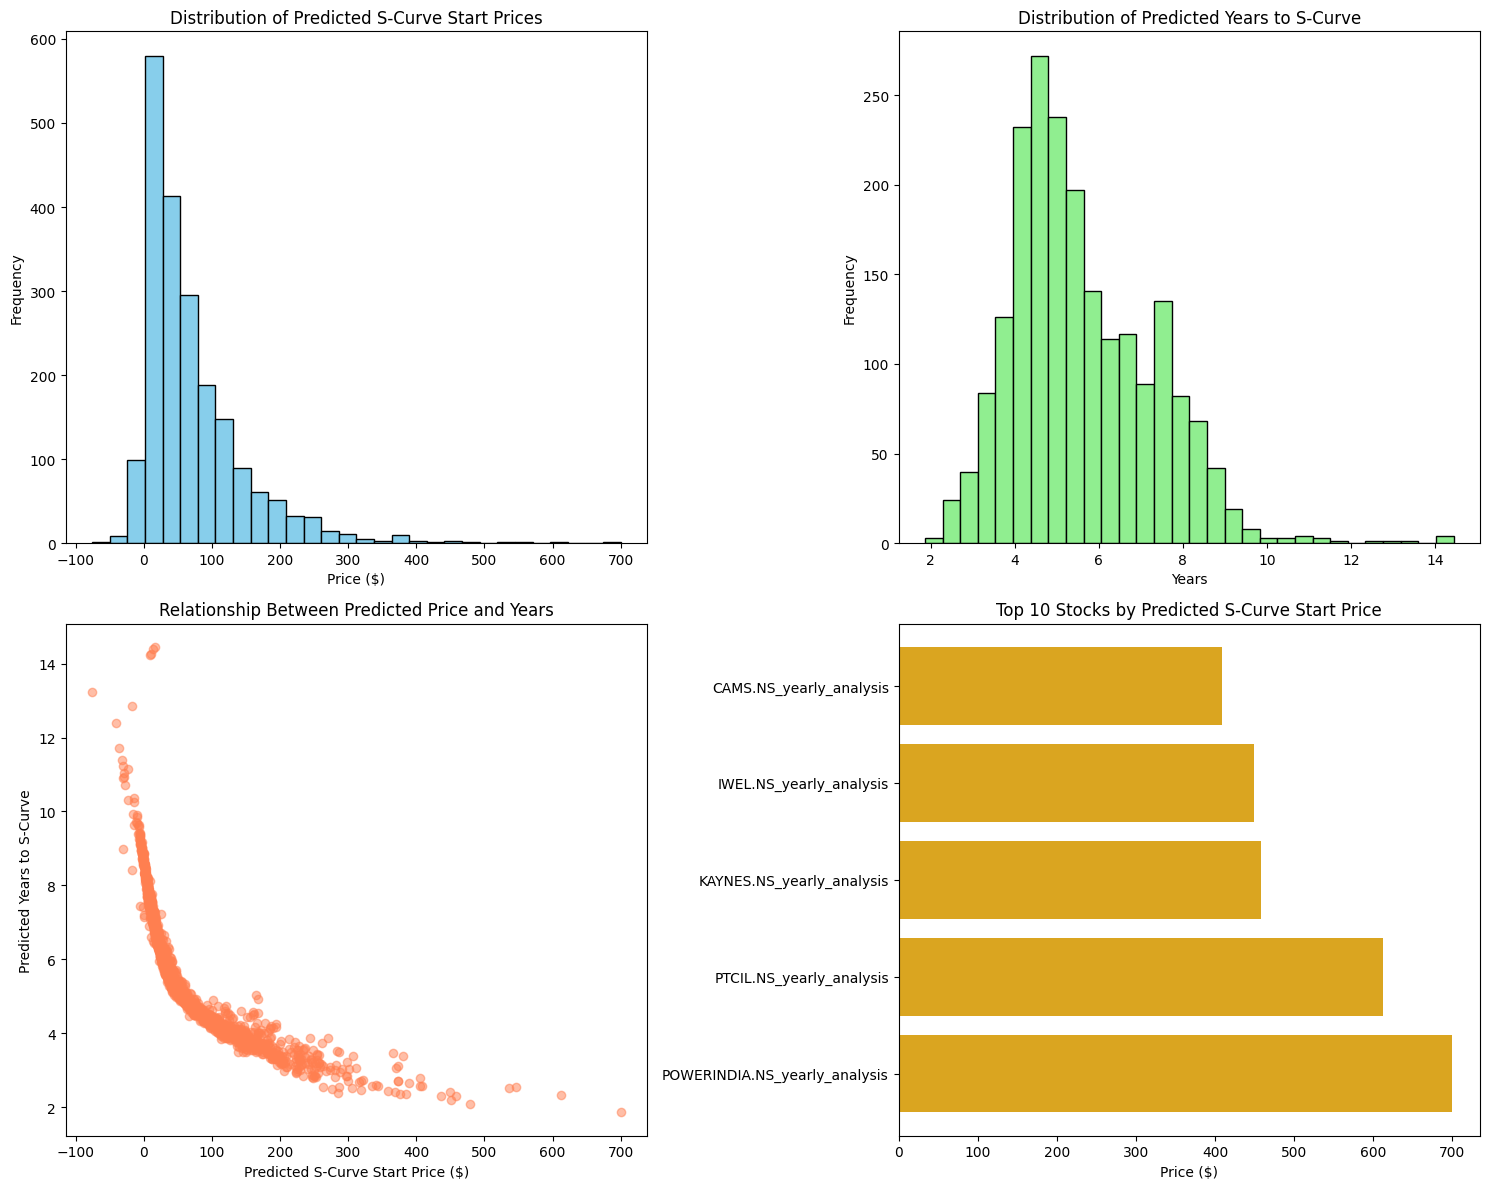


Top 10 Stocks with Earliest Predicted S-Curves:
                              Stock  Predicted_SCurve_Start_Price  \
1565  POWERINDIA.NS_yearly_analysis                    699.882629   
1593       PTCIL.NS_yearly_analysis                    479.243774   
1563  POWERINDIA.NS_yearly_analysis                    450.193146   
1045      KAYNES.NS_yearly_analysis                    458.676300   
1046      KAYNES.NS_yearly_analysis                    435.583313   
1595       PTCIL.NS_yearly_analysis                    612.052734   
752        GLAND.NS_yearly_analysis                    376.715576   
1562  POWERINDIA.NS_yearly_analysis                    385.072937   
929   INDIGOPNTS.NS_yearly_analysis                    285.550842   
991         IWEL.NS_yearly_analysis                    448.932892   

      Predicted_Years_to_SCurve  
1565                   1.863292  
1593                   2.097460  
1563                   2.206462  
1045                   2.306837  
1046                 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the saved model and scalers
model_path = "/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data/lstm_dual_output_model.keras"
X_scaler_path = "/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data/X_scaler.pkl"
price_scaler_path = "/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data/price_scaler.pkl"
years_scaler_path = "/content/drive/MyDrive/Final Data/Pre_2020/preprocessed_data/years_scaler.pkl"

# Load model and scalers
model = load_model(model_path)
X_scaler = joblib.load(X_scaler_path)
price_scaler = joblib.load(price_scaler_path)
years_scaler = joblib.load(years_scaler_path)

print("✅ Model and scalers loaded successfully.")

# Define the path to post-2020 data
post_2020_folder = '/content/drive/MyDrive/Final Data/Post_2020/stock_analysis_data'  # Adjust path as needed

# Function to preprocess post-2020 data in the same way as pre-2020 data
def load_post_2020_data(folder_path):
    df_list = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            try:
                df = pd.read_csv(file_path)
                df['Stock'] = file.replace('.csv', '')  # Add stock name for reference
                df_list.append(df)
                print(f"✅ Loaded {file}")
            except Exception as e:
                print(f"❌ Failed to read {file}: {e}")

    if not df_list:
        raise ValueError("No valid CSV files found!")

    # Concatenate all files
    df_post = pd.concat(df_list, ignore_index=True)
    print(f"✅ Total rows combined: {len(df_post)}")

    return df_post

# Load post-2020 data
try:
    df_post = load_post_2020_data(post_2020_folder)
    print("Sample of post-2020 data:")
    print(df_post.head())
    print("Columns in post-2020 data:")
    print(df_post.columns.tolist())
except Exception as e:
    print(f"Error loading post-2020 data: {e}")

# Function to prepare data for prediction
def prepare_data_for_prediction(df):
    # Save a copy of original data with stock names
    original_df = df.copy()

    # Drop non-numeric / non-useful columns like in the training data
    drop_cols = ['Valuation Status', 'Stock']
    df_processed = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle any potential S-curve columns if they exist - we don't need them for prediction
    if 'Start of S-Curve Price' in df_processed.columns:
        df_processed.drop(columns=['Start of S-Curve Price'], inplace=True)
    if 'Years to S-Curve Start' in df_processed.columns:
        df_processed.drop(columns=['Years to S-Curve Start'], inplace=True)

    # Drop rows with NaNs
    df_processed.dropna(inplace=True)

    # Ensure we have the same features as were used for training
    X_columns = df_processed.columns

    return df_processed, original_df.loc[df_processed.index], X_columns

# Function to make predictions
def predict_scurve_metrics(model, X_data, X_scaler, price_scaler, years_scaler):
    # Scale the input data
    X_scaled = X_scaler.transform(X_data)

    # Reshape for LSTM: (samples, timesteps=1, features)
    X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, years_pred_scaled = model.predict(X_scaled_lstm)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    years_pred_original = years_scaler.inverse_transform(years_pred_scaled)

    return price_pred_original, years_pred_original

# Prepare post-2020 data for prediction
try:
    df_features, df_original, X_columns = prepare_data_for_prediction(df_post)
    print("✅ Data prepared for prediction")
    print(f"Features used for prediction: {X_columns.tolist()}")

    # Make predictions
    X_data = df_features.values
    price_predictions, years_predictions = predict_scurve_metrics(
        model, X_data, X_scaler, price_scaler, years_scaler
    )

    # Add predictions to the original dataframe
    df_original['Predicted_SCurve_Start_Price'] = price_predictions
    df_original['Predicted_Years_to_SCurve'] = years_predictions

    print("✅ Predictions completed!")

    # Display sample predictions
    print("\nSample Predictions:")
    sample_results = df_original[['Stock', 'Predicted_SCurve_Start_Price', 'Predicted_Years_to_SCurve']].head(10)
    print(sample_results)

    # Calculate summary statistics
    print("\nSummary Statistics of Predictions:")
    price_stats = df_original['Predicted_SCurve_Start_Price'].describe()
    years_stats = df_original['Predicted_Years_to_SCurve'].describe()

    print("S-Curve Start Price Statistics:")
    print(price_stats)
    print("\nYears to S-Curve Statistics:")
    print(years_stats)

    # Save results to CSV
    results_path = '/content/drive/MyDrive/Final Data/Post_2020/prediction_results.csv'
    df_original.to_csv(results_path, index=False)
    print(f"\n✅ Results saved to: {results_path}")

    # Create visualization of predictions
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 12))

    # Histogram of predicted prices
    plt.subplot(2, 2, 1)
    plt.hist(df_original['Predicted_SCurve_Start_Price'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Predicted S-Curve Start Prices')
    plt.xlabel('Price ($)')
    plt.ylabel('Frequency')

    # Histogram of predicted years
    plt.subplot(2, 2, 2)
    plt.hist(df_original['Predicted_Years_to_SCurve'], bins=30, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Predicted Years to S-Curve')
    plt.xlabel('Years')
    plt.ylabel('Frequency')

    # Scatter plot of price vs years
    plt.subplot(2, 2, 3)
    plt.scatter(df_original['Predicted_SCurve_Start_Price'], df_original['Predicted_Years_to_SCurve'],
                alpha=0.5, color='coral')
    plt.title('Relationship Between Predicted Price and Years')
    plt.xlabel('Predicted S-Curve Start Price ($)')
    plt.ylabel('Predicted Years to S-Curve')

    # Top 10 stocks by predicted price
    plt.subplot(2, 2, 4)
    top_price = df_original.sort_values('Predicted_SCurve_Start_Price', ascending=False).head(10)
    bars = plt.barh(top_price['Stock'], top_price['Predicted_SCurve_Start_Price'], color='goldenrod')
    plt.title('Top 10 Stocks by Predicted S-Curve Start Price')
    plt.xlabel('Price ($)')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Final Data/Post_2020/prediction_visualization.png')
    plt.show()

    # Find stocks with the earliest predicted S-curve (lowest years value)
    early_scurve = df_original.sort_values('Predicted_Years_to_SCurve').head(10)
    print("\nTop 10 Stocks with Earliest Predicted S-Curves:")
    print(early_scurve[['Stock', 'Predicted_SCurve_Start_Price', 'Predicted_Years_to_SCurve']])

    # Find stocks with the highest predicted S-curve prices
    high_price = df_original.sort_values('Predicted_SCurve_Start_Price', ascending=False).head(10)
    print("\nTop 10 Stocks with Highest Predicted S-Curve Prices:")
    print(high_price[['Stock', 'Predicted_SCurve_Start_Price', 'Predicted_Years_to_SCurve']])

    # Optional: Calculate a combined score (normalize and combine both metrics)
    # Higher price and lower years are better
    max_price = df_original['Predicted_SCurve_Start_Price'].max()
    max_years = df_original['Predicted_Years_to_SCurve'].max()

    df_original['Price_Score'] = df_original['Predicted_SCurve_Start_Price'] / max_price  # Higher is better
    df_original['Years_Score'] = 1 - (df_original['Predicted_Years_to_SCurve'] / max_years)  # Lower years = higher score

    # Combined score (equal weight to both factors)
    df_original['Combined_Score'] = (df_original['Price_Score'] + df_original['Years_Score']) / 2

    # Top stocks by combined score
    top_combined = df_original.sort_values('Combined_Score', ascending=False).head(20)
    print("\nTop 20 Stocks by Combined Score (Price and Years):")
    print(top_combined[['Stock', 'Predicted_SCurve_Start_Price', 'Predicted_Years_to_SCurve', 'Combined_Score']])

    # Save the enriched results with scores
    df_original.to_csv('/content/drive/MyDrive/Final Data/Post_2020/prediction_results_with_scores.csv', index=False)
    print("\n✅ Results with scores saved successfully.")

    # Create a classification of stocks
    def classify_stock(row):
        price = row['Predicted_SCurve_Start_Price']
        years = row['Predicted_Years_to_SCurve']

        price_threshold = price_stats['75%']  # 75th percentile for price
        years_threshold = years_stats['25%']  # 25th percentile for years (lower is better)

        if price >= price_threshold and years <= years_threshold:
            return "Top Performer (High Price, Early S-Curve)"
        elif price >= price_threshold:
            return "High Price Potential"
        elif years <= years_threshold:
            return "Early S-Curve Potential"
        else:
            combined_score = row['Combined_Score']
            combined_threshold = df_original['Combined_Score'].quantile(0.7)  # 70th percentile

            if combined_score >= combined_threshold:
                return "Good Balance"
            else:
                return "Average Potential"

    df_original['Classification'] = df_original.apply(classify_stock, axis=1)

    # Count by classification
    class_counts = df_original['Classification'].value_counts()
    print("\nStock Classifications:")
    print(class_counts)

    # Show examples of each classification
    for classification in df_original['Classification'].unique():
        print(f"\nSample stocks classified as '{classification}':")
        sample = df_original[df_original['Classification'] == classification].head(5)
        print(sample[['Stock', 'Predicted_SCurve_Start_Price', 'Predicted_Years_to_SCurve', 'Combined_Score']])

    # Save the final results with classifications
    final_path = '/content/drive/MyDrive/Final Data/Post_2020/final_stock_predictions.csv'
    df_original.to_csv(final_path, index=False)
    print(f"\n✅ Final results with classifications saved to: {final_path}")

except Exception as e:
    print(f"Error during prediction: {e}")
    import traceback
    traceback.print_exc()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Required libraries imported.
✅ Directories set.

==== PART 1: TRAINING ON PRE-2020 DATA ====
✅ Loaded GLOBALVECT.NS_yearly_analysis.csv
✅ Loaded GMRAIRPORT.NS_yearly_analysis.csv
✅ Loaded GMMPFAUDLR.NS_yearly_analysis.csv
✅ Loaded GMDCLTD.NS_yearly_analysis.csv
✅ Loaded GNA.NS_yearly_analysis.csv
✅ Loaded GOACARBON.NS_yearly_analysis.csv
✅ Loaded GNFC.NS_yearly_analysis.csv
✅ Loaded GOCLCORP.NS_yearly_analysis.csv
✅ Loaded GODREJAGRO.NS_yearly_analysis.csv
✅ Loaded GODFRYPHLP.NS_yearly_analysis.csv
✅ Loaded GODREJIND.NS_yearly_analysis.csv
✅ Loaded GODREJCP.NS_yearly_analysis.csv
✅ Loaded GOENKA.NS_yearly_analysis.csv
✅ Loaded GODREJPROP.NS_yearly_analysis.csv
✅ Loaded GOKUL.NS_yearly_analysis.csv
✅ Loaded GOKULAGRO.NS_yearly_analysis.csv
✅ Loaded GOKEX.NS_yearly_analysis.csv
✅ Loaded GOLDENTOBC.NS_yearly_analysis.csv
✅ Loaded GOLDIAM.NS_yearly_analysis.csv

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 1, 64)     │     20,736 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,218 (129.76 KB)

 Trainable params: 33,218 (129.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0279 - price_output_loss: 7.2108e-04 - price_output_mae: 0.0118 - year_output_loss: 0.0271 - year_output_mae: 0.1192 - val_loss: 0.0240 - val_price_output_loss: 9.1957e-04 - val_price_output_mae: 0.0094 - val_year_output_loss: 0.0230 - val_year_output_mae: 0.1136
Epoch 2/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0247 - price_output_loss: 9.0642e-04 - price_output_mae: 0.0106 - year_output_loss: 0.0238 - year_output_mae: 0.1141 - val_loss: 0.0236 - val_price_output_loss: 8.9845e-04 - val_price_output_mae: 0.0105 - val_year_output_loss: 0.0225 - val_year_output_mae: 0.1113
Epoch 3/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0233 - price_output_loss: 4.9958e-04 - price_output_mae: 0.0089 - year_output_loss: 0.0228 - year_output_mae: 0.1115 - val_loss: 0.0234 - val_price_output_loss: 8.6397e-04 - val_price_output_mae: 0.0081 - val_year_output_loss: 0.0225 - val_year_output_mae: 0.1125
Epoch 4/50
462/462 ━━━

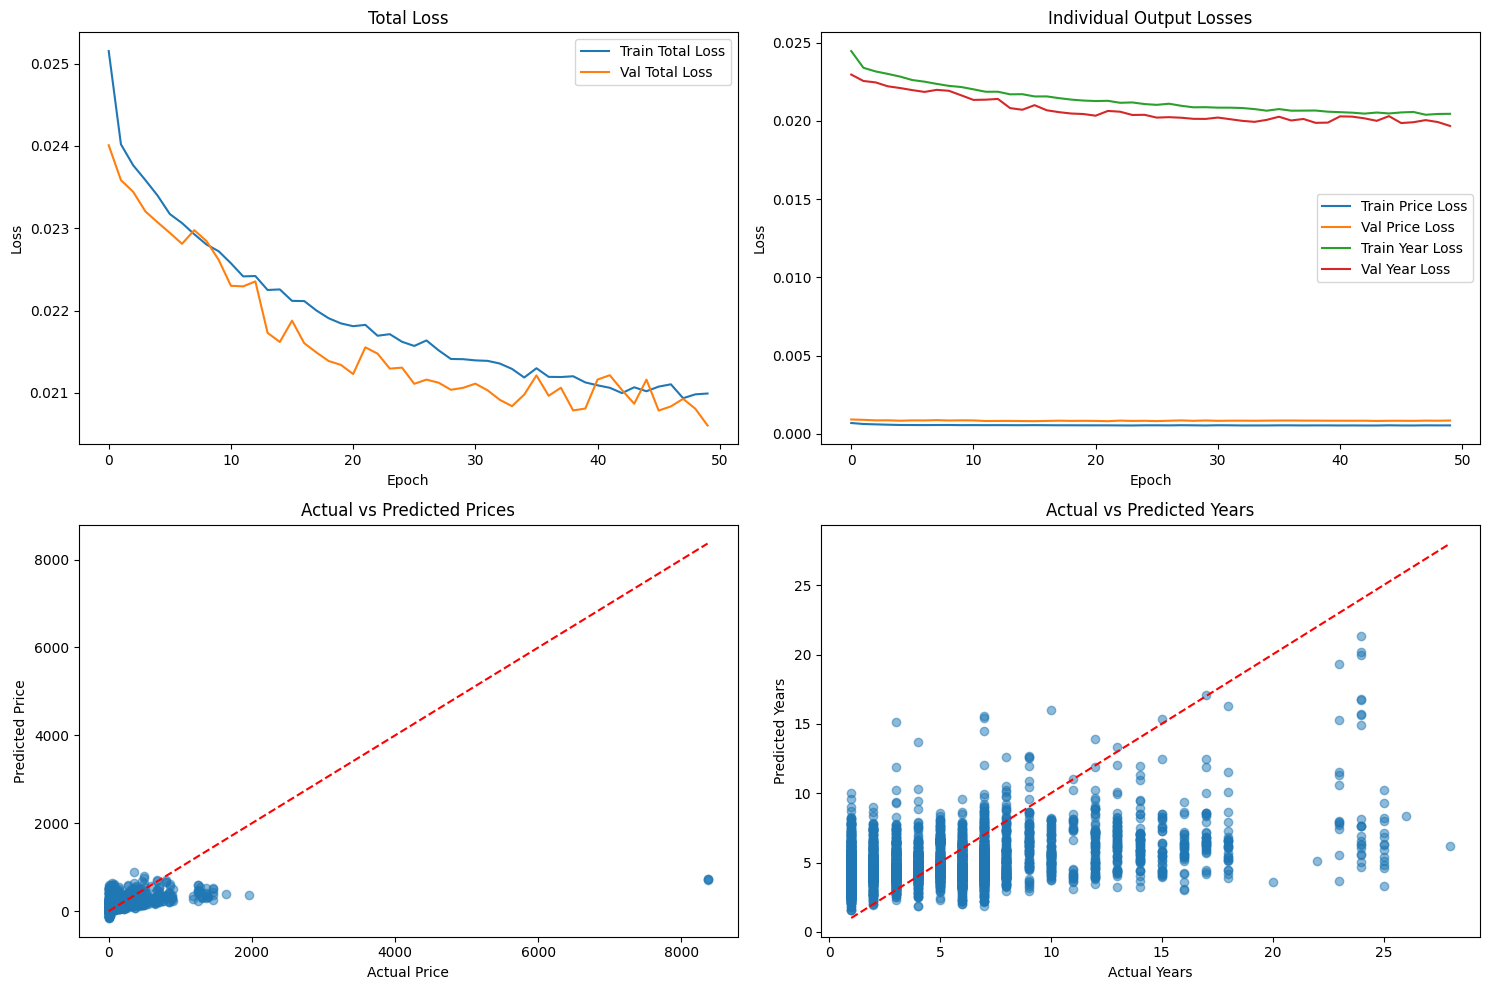


==== PART 2: PREDICTING ON POST-2020 DATA ====
✅ Loaded AAATECH.NS_yearly_analysis.csv
✅ Loaded 3IINFOLTD.NS_yearly_analysis.csv
✅ Loaded AAKASH.NS_yearly_analysis.csv
✅ Loaded AADHARHFC.NS_yearly_analysis.csv
✅ Loaded AAREYDRUGS.NS_yearly_analysis.csv
✅ Loaded AARTECH.NS_yearly_analysis.csv
✅ Loaded AARON.NS_yearly_analysis.csv
✅ Loaded AARVI.NS_yearly_analysis.csv
✅ Loaded AARTISURF.NS_yearly_analysis.csv
✅ Loaded AARTIPHARM.NS_yearly_analysis.csv
✅ Loaded ABMINTLLTD.NS_yearly_analysis.csv
✅ Loaded ABDL.NS_yearly_analysis.csv
✅ Loaded ABINFRA.NS_yearly_analysis.csv
✅ Loaded ABSLAMC.NS_yearly_analysis.csv
✅ Loaded ACMESOLAR.NS_yearly_analysis.csv
✅ Loaded ACL.NS_yearly_analysis.csv
✅ Loaded ADL.NS_yearly_analysis.csv
✅ Loaded ACI.NS_yearly_analysis.csv
✅ Loaded ACEINTEG.NS_yearly_analysis.csv
✅ Loaded ACCURACY.NS_yearly_analysis.csv
✅ Loaded AEROFLEX.NS_yearly_analysis.csv
✅ Loaded AETHER.NS_yearly_analysis.csv
✅ Loaded AFCONS.NS_yearly_analysis.csv
✅ Loaded AGARWALEYE.NS_yearly_anal

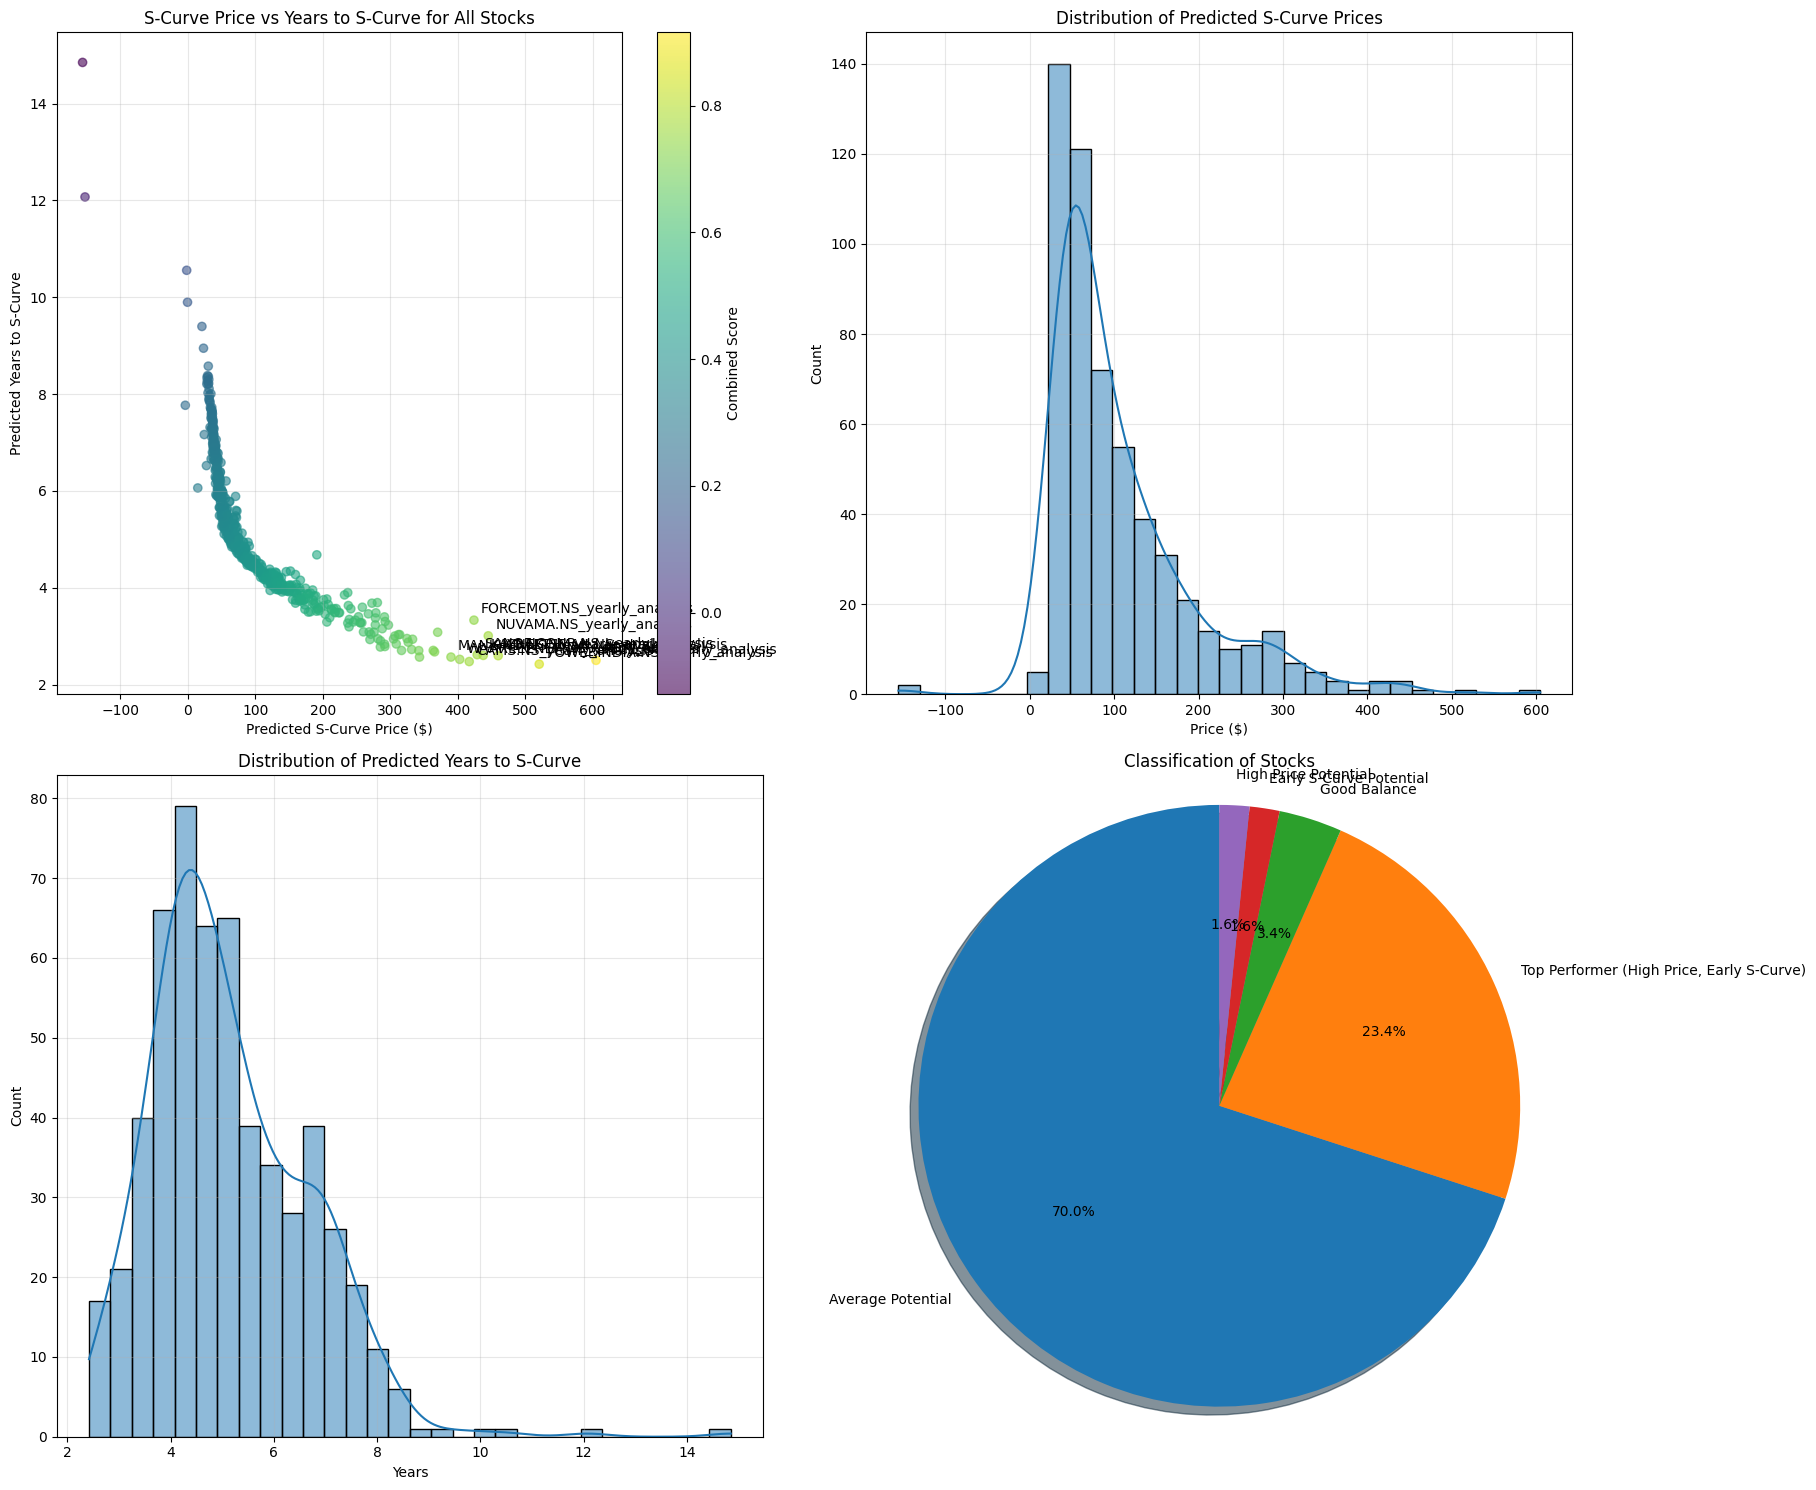

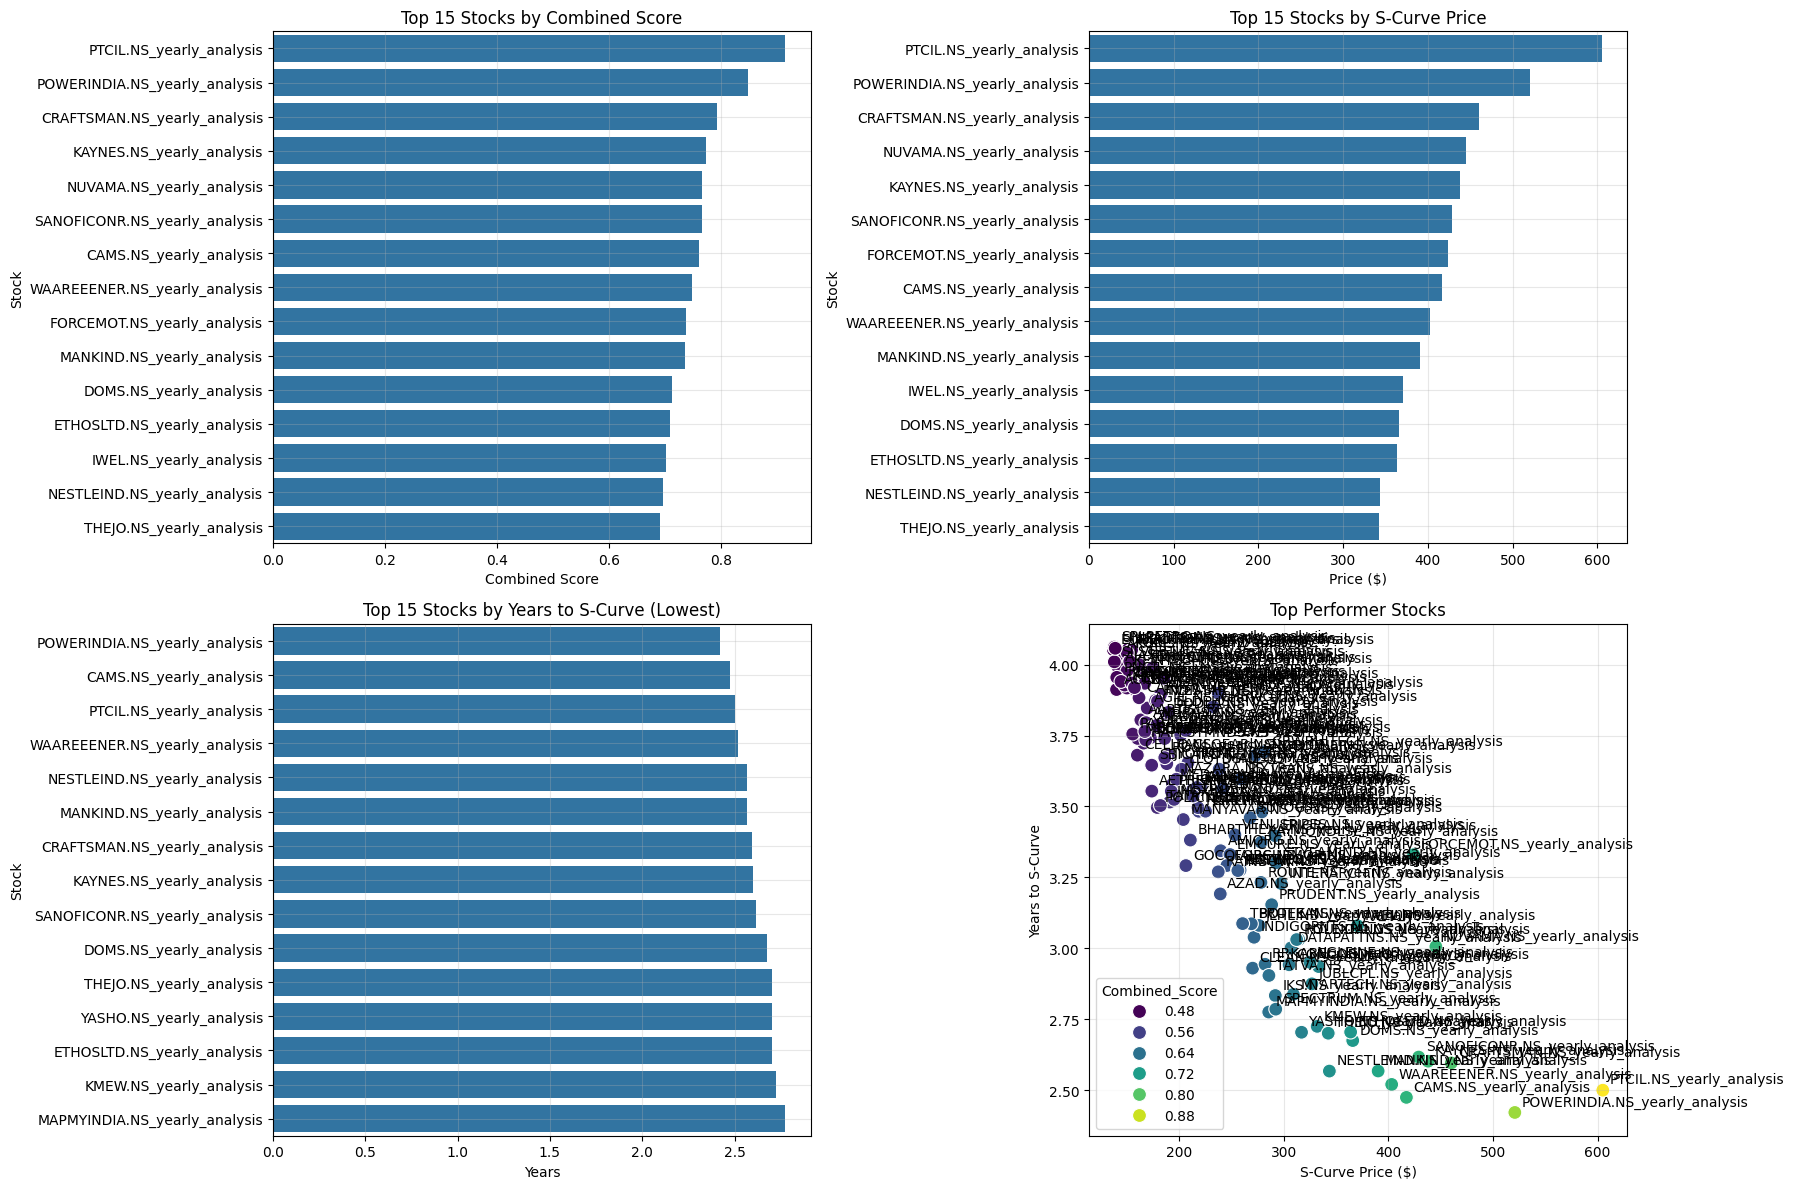


===== FINAL STOCK RECOMMENDATIONS =====

Top Performer Stocks (High Price, Early S-Curve):
                             Stock  SCurve_Start_Price  Years_to_SCurve  \
7     AARTISURF.NS_yearly_analysis          163.128693         3.805225   
8    AARTIPHARM.NS_yearly_analysis          166.889908         3.934165   
14          ACI.NS_yearly_analysis          139.890259         3.912295   
18       AETHER.NS_yearly_analysis          173.630997         3.554141   
23        AGIIL.NS_yearly_analysis          169.230652         3.847043   
..                             ...                 ...              ...   
528      UTIAMC.NS_yearly_analysis          206.180359         3.767647   
533  VENUSPIPES.NS_yearly_analysis          253.116730         3.399952   
543  WAAREEENER.NS_yearly_analysis          403.080475         2.519876   
553       YASHO.NS_yearly_analysis          316.859863         2.703818   
555       YUKEN.NS_yearly_analysis          166.987076         3.764335   

     Co

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Required libraries imported.")

# Set paths
pre_2020_folder = '/content/drive/MyDrive/Final Data/Pre_2020/stock_analysis_data'
post_2020_folder = '/content/drive/MyDrive/Final Data/Post_2020/stock_analysis_data'
save_dir = "/content/drive/MyDrive/Final Data/Models"

# Create directory for saving model and results
os.makedirs(save_dir, exist_ok=True)

print("✅ Directories set.")

# PART 1: TRAINING ON PRE-2020 DATA
print("\n==== PART 1: TRAINING ON PRE-2020 DATA ====")

# Load pre-2020 data
def load_pre_2020_data(folder_path):
    df_list = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            try:
                df = pd.read_csv(file_path)
                df['Stock'] = file.replace('.csv', '')  # Inject stock name
                df_list.append(df)
                print(f"✅ Loaded {file}")
            except Exception as e:
                print(f"❌ Failed to read {file}: {e}")

    if not df_list:
        raise ValueError("No valid CSV files found!")

    # Concatenate all files into one DataFrame
    df_pre = pd.concat(df_list, ignore_index=True)
    print(f"✅ Total rows combined: {len(df_pre)}")

    return df_pre

# Load and preprocess the training data
df_pre = load_pre_2020_data(pre_2020_folder)
print("✅ Pre-2020 data loaded successfully.")

# Display columns to verify
print("\nColumns in pre-2020 data:")
print(df_pre.columns.tolist())

# Drop non-numeric / non-useful columns
drop_cols = ['Valuation Status', 'Stock']  # keep 'Year' for potential use
df_pre.drop(columns=[col for col in drop_cols if col in df_pre.columns], inplace=True)

# Drop rows with NaNs
df_pre.dropna(inplace=True)

# Verify S-curve columns exist
if 'Start of S-Curve Price' not in df_pre.columns or 'Years to S-Curve Start' not in df_pre.columns:
    raise ValueError("S-curve target columns not found in pre-2020 data")

# Extract input features (X) and targets (y)
X = df_pre.drop(columns=['Start of S-Curve Price', 'Years to S-Curve Start']).values
y_price = df_pre['Start of S-Curve Price'].values
y_years = df_pre['Years to S-Curve Start'].values

print(f"✅ Features and targets extracted: {X.shape[1]} features, {len(y_price)} samples")

# Normalize X
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)

# Normalize y_price and y_years
price_scaler = MinMaxScaler().fit(y_price.reshape(-1, 1))
y_price_scaled = price_scaler.transform(y_price.reshape(-1, 1))

years_scaler = MinMaxScaler().fit(y_years.reshape(-1, 1))
y_years_scaled = years_scaler.transform(y_years.reshape(-1, 1))

# Reshape for LSTM (samples, timesteps=1, features)
X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, yp_train, yp_test, yy_train, yy_test = train_test_split(
    X_scaled_lstm, y_price_scaled, y_years_scaled, test_size=0.2, random_state=42
)

print("✅ Data normalized and split")
print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

# Build the model
# Input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# Shared LSTM layers
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = LSTM(32)(x)
x = Dropout(0.2)(x)

# Two output heads
price_output = Dense(1, name='price_output')(x)
year_output = Dense(1, name='year_output')(x)

# Model definition
model = Model(inputs=input_layer, outputs=[price_output, year_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'price_output': 'mse', 'year_output': 'mse'},
              metrics={'price_output': 'mae', 'year_output': 'mae'})

print("✅ Model built and compiled")
model.summary()

# Train the model
history = model.fit(
    X_train,
    {'price_output': yp_train, 'year_output': yy_train},
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

print("✅ Model training completed")

# Evaluate the model
loss, price_loss, year_loss, price_mae, year_mae = model.evaluate(
    X_test,
    {'price_output': yp_test, 'year_output': yy_test}
)

print(f"Price MAE (scaled): {price_mae:.4f}, Years MAE (scaled): {year_mae:.4f}")

# Get predictions (scaled values)
price_pred_scaled, year_pred_scaled = model.predict(X_test)

# Convert scaled predictions back to original scale
price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
year_pred_original = years_scaler.inverse_transform(year_pred_scaled)

# Convert scaled test values back to original scale for comparison
price_test_original = price_scaler.inverse_transform(yp_test)
year_test_original = years_scaler.inverse_transform(yy_test)

# Calculate MAE in original scale
from sklearn.metrics import mean_absolute_error

price_mae_original = mean_absolute_error(price_test_original, price_pred_original)
year_mae_original = mean_absolute_error(year_test_original, year_pred_original)

print(f"Price MAE (original scale): {price_mae_original:.4f}, Years MAE (original scale): {year_mae_original:.4f}")

# Save the model and scalers
model.save(os.path.join(save_dir, "lstm_dual_output_model.keras"))
joblib.dump(X_scaler, os.path.join(save_dir, "X_scaler.pkl"))
joblib.dump(price_scaler, os.path.join(save_dir, "price_scaler.pkl"))
joblib.dump(years_scaler, os.path.join(save_dir, "years_scaler.pkl"))

print("✅ Model and scalers saved")

# Plot training history
plt.figure(figsize=(15, 10))

# Main loss plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Individual losses
plt.subplot(2, 2, 2)
plt.plot(history.history['price_output_loss'], label='Train Price Loss')
plt.plot(history.history['val_price_output_loss'], label='Val Price Loss')
plt.plot(history.history['year_output_loss'], label='Train Year Loss')
plt.plot(history.history['val_year_output_loss'], label='Val Year Loss')
plt.title('Individual Output Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Scatter plot of actual vs predicted prices
plt.subplot(2, 2, 3)
plt.scatter(price_test_original, price_pred_original, alpha=0.5)
plt.plot([price_test_original.min(), price_test_original.max()],
         [price_test_original.min(), price_test_original.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Scatter plot of actual vs predicted years
plt.subplot(2, 2, 4)
plt.scatter(year_test_original, year_pred_original, alpha=0.5)
plt.plot([year_test_original.min(), year_test_original.max()],
         [year_test_original.min(), year_test_original.max()], 'r--')
plt.title('Actual vs Predicted Years')
plt.xlabel('Actual Years')
plt.ylabel('Predicted Years')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "model_performance.png"))
plt.show()

print("\n==== PART 2: PREDICTING ON POST-2020 DATA ====")

# Function to load post-2020 data but keep files separate
def load_post_2020_data(folder_path):
    stock_dataframes = {}
    all_files = []

    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            stock_name = file.replace('.csv', '')
            file_path = os.path.join(folder_path, file)

            try:
                df = pd.read_csv(file_path)
                df['Stock'] = stock_name  # Add stock name for reference
                stock_dataframes[stock_name] = df
                all_files.append(file)
                print(f"✅ Loaded {file}")
            except Exception as e:
                print(f"❌ Failed to read {file}: {e}")

    if not stock_dataframes:
        raise ValueError("No valid CSV files found!")

    print(f"✅ Loaded data for {len(stock_dataframes)} stocks")

    return stock_dataframes

# Function to prepare data for prediction
def prepare_data_for_prediction(df):
    # Drop non-numeric / non-useful columns like in the training data
    drop_cols = ['Valuation Status', 'Stock']
    df_processed = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle any potential S-curve columns if they exist - we don't need them for prediction
    if 'Start of S-Curve Price' in df_processed.columns:
        df_processed.drop(columns=['Start of S-Curve Price'], inplace=True)
    if 'Years to S-Curve Start' in df_processed.columns:
        df_processed.drop(columns=['Years to S-Curve Start'], inplace=True)

    # Drop rows with NaNs
    df_processed.dropna(inplace=True)

    return df_processed

# Function to make predictions for a single dataframe
def predict_scurve_metrics(model, X_data, X_scaler, price_scaler, years_scaler):
    # Scale the input data
    X_scaled = X_scaler.transform(X_data)

    # Reshape for LSTM: (samples, timesteps=1, features)
    X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, years_pred_scaled = model.predict(X_scaled_lstm)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    years_pred_original = years_scaler.inverse_transform(years_pred_scaled)

    # Calculate the median prediction for this stock (more robust than mean)
    median_price = np.median(price_pred_original)
    median_years = np.median(years_pred_original)

    return median_price, median_years

# Main function to process all stocks
def predict_all_stocks(stock_dataframes, model, X_scaler, price_scaler, years_scaler):
    results = []

    for stock_name, df in stock_dataframes.items():
        try:
            # Prepare data
            df_processed = prepare_data_for_prediction(df)

            if len(df_processed) == 0:
                print(f"⚠️ No valid data rows for {stock_name} after preprocessing. Skipping.")
                continue

            # Make predictions
            X_data = df_processed.values
            median_price, median_years = predict_scurve_metrics(
                model, X_data, X_scaler, price_scaler, years_scaler
            )

            # Store results
            results.append({
                'Stock': stock_name,
                'SCurve_Start_Price': float(median_price),
                'Years_to_SCurve': float(median_years),
                'Datapoints_Used': len(df_processed)
            })

            print(f"✅ {stock_name}: Predicted S-Curve Price: ${median_price:.2f}, Years: {median_years:.2f}")

        except Exception as e:
            print(f"❌ Error processing {stock_name}: {e}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

# Load post-2020 data
stock_dataframes = load_post_2020_data(post_2020_folder)

# Process all stocks
results_df = predict_all_stocks(stock_dataframes, model, X_scaler, price_scaler, years_scaler)

print("\n===== PREDICTION RESULTS =====")
print(f"Predicted S-Curve metrics for {len(results_df)} stocks")

# Sort by years to S-curve (ascending) to find the earliest opportunities
early_opportunities = results_df.sort_values('Years_to_SCurve').head(20)
print("\nTop 20 Stocks with Earliest Predicted S-Curves:")
print(early_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve']])

# Sort by S-curve price (descending) to find highest potential returns
high_returns = results_df.sort_values('SCurve_Start_Price', ascending=False).head(20)
print("\nTop 20 Stocks with Highest Predicted S-Curve Prices:")
print(high_returns[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve']])

# Calculate a combined score (normalize and combine both metrics)
max_price = results_df['SCurve_Start_Price'].max()
max_years = results_df['Years_to_SCurve'].max()

# Normalize scores (0-1 range)
results_df['Price_Score'] = results_df['SCurve_Start_Price'] / max_price  # Higher is better
results_df['Years_Score'] = 1 - (results_df['Years_to_SCurve'] / max_years)  # Lower years = higher score

# Combined score (equal weight to both factors)
results_df['Combined_Score'] = (results_df['Price_Score'] + results_df['Years_Score']) / 2

# Find the best overall opportunities
best_opportunities = results_df.sort_values('Combined_Score', ascending=False).head(20)
print("\nTop 20 Best Overall Opportunities (Combined Score):")
print(best_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve', 'Combined_Score']])

# Create classifications
def classify_stock(row):
    price = row['SCurve_Start_Price']
    years = row['Years_to_SCurve']

    price_75th = results_df['SCurve_Start_Price'].quantile(0.75)
    years_25th = results_df['Years_to_SCurve'].quantile(0.25)

    if price >= price_75th and years <= years_25th:
        return "Top Performer (High Price, Early S-Curve)"
    elif price >= price_75th:
        return "High Price Potential"
    elif years <= years_25th:
        return "Early S-Curve Potential"
    else:
        combined_score = row['Combined_Score']
        combined_threshold = results_df['Combined_Score'].quantile(0.7)

        if combined_score >= combined_threshold:
            return "Good Balance"
        else:
            return "Average Potential"

results_df['Classification'] = results_df.apply(classify_stock, axis=1)

# Count by classification
class_counts = results_df['Classification'].value_counts()
print("\nStock Classifications:")
print(class_counts)

# Save results
results_path = os.path.join(save_dir, "stock_scurve_predictions.csv")
results_df.to_csv(results_path, index=False)
print(f"\n✅ Results saved to: {results_path}")

# Create visualizations
plt.figure(figsize=(18, 15))

# Scatter plot of all stocks
plt.subplot(2, 2, 1)
scatter = plt.scatter(results_df['SCurve_Start_Price'], results_df['Years_to_SCurve'],
            alpha=0.6, c=results_df['Combined_Score'], cmap='viridis')
plt.colorbar(scatter, label='Combined Score')

# Label the top 10 stocks
top_10 = results_df.sort_values('Combined_Score', ascending=False).head(10)
for i, row in top_10.iterrows():
    plt.annotate(row['Stock'],
                 (row['SCurve_Start_Price'], row['Years_to_SCurve']),
                 xytext=(5, 5), textcoords='offset points')

plt.title('S-Curve Price vs Years to S-Curve for All Stocks')
plt.xlabel('Predicted S-Curve Price ($)')
plt.ylabel('Predicted Years to S-Curve')
plt.grid(True, alpha=0.3)

# Distribution of S-Curve prices
plt.subplot(2, 2, 2)
sns.histplot(results_df['SCurve_Start_Price'], bins=30, kde=True)
plt.title('Distribution of Predicted S-Curve Prices')
plt.xlabel('Price ($)')
plt.grid(True, alpha=0.3)

# Distribution of Years to S-Curve
plt.subplot(2, 2, 3)
sns.histplot(results_df['Years_to_SCurve'], bins=30, kde=True)
plt.title('Distribution of Predicted Years to S-Curve')
plt.xlabel('Years')
plt.grid(True, alpha=0.3)

# Classification breakdown
plt.subplot(2, 2, 4)
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.axis('equal')
plt.title('Classification of Stocks')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "scurve_prediction_visualizations.png"))
plt.show()

# Create a second visualization - recommendations
plt.figure(figsize=(18, 12))

# Top 15 by combined score
plt.subplot(2, 2, 1)
top_combined = results_df.sort_values('Combined_Score', ascending=False).head(15)
sns.barplot(x='Combined_Score', y='Stock', data=top_combined)
plt.title('Top 15 Stocks by Combined Score')
plt.xlabel('Combined Score')
plt.grid(True, alpha=0.3)

# Top 15 by price
plt.subplot(2, 2, 2)
top_price = results_df.sort_values('SCurve_Start_Price', ascending=False).head(15)
sns.barplot(x='SCurve_Start_Price', y='Stock', data=top_price)
plt.title('Top 15 Stocks by S-Curve Price')
plt.xlabel('Price ($)')
plt.grid(True, alpha=0.3)

# Top 15 by years (low values)
plt.subplot(2, 2, 3)
top_years = results_df.sort_values('Years_to_SCurve').head(15)
sns.barplot(x='Years_to_SCurve', y='Stock', data=top_years)
plt.title('Top 15 Stocks by Years to S-Curve (Lowest)')
plt.xlabel('Years')
plt.grid(True, alpha=0.3)

# Top performers classification
plt.subplot(2, 2, 4)
top_performers = results_df[results_df['Classification'] == 'Top Performer (High Price, Early S-Curve)']
if len(top_performers) > 0:
    sns.scatterplot(x='SCurve_Start_Price', y='Years_to_SCurve',
                 hue='Combined_Score', data=top_performers, s=100, palette='viridis')

    for i, row in top_performers.iterrows():
        plt.annotate(row['Stock'],
                 (row['SCurve_Start_Price'], row['Years_to_SCurve']),
                 xytext=(5, 5), textcoords='offset points')

    plt.title('Top Performer Stocks')
    plt.xlabel('S-Curve Price ($)')
    plt.ylabel('Years to S-Curve')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No Top Performers', horizontalalignment='center',
            verticalalignment='center', fontsize=14)
    plt.title('Top Performer Stocks')
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "top_stock_recommendations.png"))
plt.show()

# Output final recommendation table
print("\n===== FINAL STOCK RECOMMENDATIONS =====")
print("\nTop Performer Stocks (High Price, Early S-Curve):")
top_performers = results_df[results_df['Classification'] == 'Top Performer (High Price, Early S-Curve)']
if len(top_performers) > 0:
    print(top_performers[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve', 'Combined_Score']])
else:
    print("No stocks classified as Top Performers")

print("\nEarly S-Curve Potential (Quick Growth Opportunities):")
early_stocks = results_df[results_df['Classification'] == 'Early S-Curve Potential'].head(10)
print(early_stocks[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve', 'Combined_Score']])

print("\nHigh Price Potential (Maximum Return Opportunities):")
high_price_stocks = results_df[results_df['Classification'] == 'High Price Potential'].head(10)
print(high_price_stocks[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve', 'Combined_Score']])

print("\n✅ Analysis complete! Check the saved files for detailed results.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# Set paths
post_2020_folder = '/content/drive/MyDrive/Final Data/Post_2020/stock_analysis_data'
models_dir = "/content/drive/MyDrive/Final Data/Models"
output_dir = "/content/drive/MyDrive/Final Data/Combined_Results"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

print("✅ Directories set.")

# Load the model and scalers
model = load_model(os.path.join(models_dir, "lstm_dual_output_model.keras"))
X_scaler = joblib.load(os.path.join(models_dir, "X_scaler.pkl"))
price_scaler = joblib.load(os.path.join(models_dir, "price_scaler.pkl"))
years_scaler = joblib.load(os.path.join(models_dir, "years_scaler.pkl"))

print("✅ Model and scalers loaded.")

# Load the previously saved predictions for reference
try:
    predictions_df = pd.read_csv(os.path.join(models_dir, "stock_scurve_predictions.csv"))
    print("✅ Previous predictions loaded.")
except:
    print("⚠️ Could not find previous predictions file. Will create new predictions.")
    predictions_df = None

# Function to prepare data for prediction
def prepare_data_for_prediction(df):
    # Make a copy of the original dataframe to preserve all columns
    df_original = df.copy()

    # Create a copy for processing that will exclude certain columns
    df_processed = df.copy()

    # Drop non-numeric / non-useful columns for the model
    drop_cols = ['Valuation Status', 'Stock']
    df_processed = df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns])

    # Handle any potential S-curve columns if they exist - we don't need them for prediction
    if 'Start of S-Curve Price' in df_processed.columns:
        df_processed.drop(columns=['Start of S-Curve Price'], inplace=True)
    if 'Years to S-Curve Start' in df_processed.columns:
        df_processed.drop(columns=['Years to S-Curve Start'], inplace=True)

    # Store indices of rows without NaNs for later use
    valid_indices = df_processed.dropna().index

    # Drop rows with NaNs for processing
    df_processed = df_processed.dropna()

    return df_processed, df_original, valid_indices

# Function to make predictions for a single dataframe
def predict_scurve_metrics(model, X_data, X_scaler, price_scaler, years_scaler):
    # Scale the input data
    X_scaled = X_scaler.transform(X_data)

    # Reshape for LSTM: (samples, timesteps=1, features)
    X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, years_pred_scaled = model.predict(X_scaled_lstm, verbose=0)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    years_pred_original = years_scaler.inverse_transform(years_pred_scaled)

    return price_pred_original, years_pred_original

# Process each stock file separately
for file in os.listdir(post_2020_folder):
    if file.endswith('.csv'):
        stock_name = file.replace('.csv', '')
        file_path = os.path.join(post_2020_folder, file)

        try:
            # Load the stock data
            df = pd.read_csv(file_path)
            df['Stock'] = stock_name  # Add stock name for reference
            print(f"Processing {stock_name}...")

            # Prepare data for prediction while preserving original data
            df_processed, df_original, valid_indices = prepare_data_for_prediction(df)

            if len(df_processed) == 0:
                print(f"⚠️ No valid data rows for {stock_name} after preprocessing. Skipping.")
                continue

            # Make predictions
            X_data = df_processed.values
            price_pred_original, years_pred_original = predict_scurve_metrics(
                model, X_data, X_scaler, price_scaler, years_scaler
            )

            # Calculate median values for the stock
            median_price = np.median(price_pred_original)
            median_years = np.median(years_pred_original)

            # Round years to whole number as requested
            whole_years = round(float(median_years))

            # Or get the values from previously saved predictions if available
            if predictions_df is not None and stock_name in predictions_df['Stock'].values:
                stock_pred = predictions_df[predictions_df['Stock'] == stock_name].iloc[0]
                median_price = stock_pred['SCurve_Start_Price']
                median_years = stock_pred['Years_to_SCurve']
                whole_years = round(float(median_years))

            # Add prediction columns to all rows in the original dataframe
            df_original['SCurve_Start_Price'] = median_price
            df_original['Years_to_SCurve'] = median_years
            df_original['Years_to_SCurve_Whole'] = whole_years

            # Create additional empty columns if they don't exist
            required_columns = [
                'Year', 'Market Price', 'Yearly Average Price', 'Yearly Volatility',
                'Yearly Growth', 'EPS', 'Projected EPS', 'P/E Ratio', 'Fundamental P/E',
                'Book Value', 'P/B Ratio', 'ROE', 'Intrinsic Value',
                'Intrinsic Value (Graham)', 'Intrinsic Value (Combined)',
                'Market to Intrinsic Ratio'
            ]

            for col in required_columns:
                if col not in df_original.columns:
                    df_original[col] = np.nan

            # Save as CSV
            output_path = os.path.join(output_dir, f"{stock_name}_combined.csv")
            df_original.to_csv(output_path, index=False)
            print(f"✅ Saved combined data for {stock_name}")

        except Exception as e:
            print(f"❌ Error processing {stock_name}: {e}")

print("\n✅ Processing complete! All files saved to:", output_dir)

# Create a summary CSV with all stocks and their predictions
if predictions_df is not None:
    # Use the existing predictions summary
    summary_path = os.path.join(output_dir, "all_stocks_scurve_summary.csv")
    predictions_df['Years_to_SCurve_Whole'] = predictions_df['Years_to_SCurve'].apply(lambda x: round(float(x)))
    predictions_df.to_csv(summary_path, index=False)
    print(f"✅ Summary of all stocks saved to: {summary_path}")
else:
    # Create a new summary from the processed files
    summary_rows = []
    for file in os.listdir(output_dir):
        if file.endswith('_combined.csv'):
            stock_name = file.replace('_combined.csv', '')
            df = pd.read_csv(os.path.join(output_dir, file))
            if 'SCurve_Start_Price' in df.columns and 'Years_to_SCurve' in df.columns:
                row = {
                    'Stock': stock_name,
                    'SCurve_Start_Price': df['SCurve_Start_Price'].iloc[0],
                    'Years_to_SCurve': df['Years_to_SCurve'].iloc[0],
                    'Years_to_SCurve_Whole': df['Years_to_SCurve_Whole'].iloc[0]
                }
                summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows)
    summary_path = os.path.join(output_dir, "all_stocks_scurve_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"✅ Summary of all stocks saved to: {summary_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directories set.
✅ Model and scalers loaded.
✅ Previous predictions loaded.
Processing AAATECH.NS_yearly_analysis...
✅ Saved combined data for AAATECH.NS_yearly_analysis
Processing 3IINFOLTD.NS_yearly_analysis...
⚠️ No valid data rows for 3IINFOLTD.NS_yearly_analysis after preprocessing. Skipping.
Processing AAKASH.NS_yearly_analysis...
✅ Saved combined data for AAKASH.NS_yearly_analysis
Processing AADHARHFC.NS_yearly_analysis...
✅ Saved combined data for AADHARHFC.NS_yearly_analysis
Processing AAREYDRUGS.NS_yearly_analysis...
✅ Saved combined data for AAREYDRUGS.NS_yearly_analysis
Processing AARTECH.NS_yearly_analysis...
✅ Saved combined data for AARTECH.NS_yearly_analysis
Processing AARON.NS_yearly_analysis...
✅ Saved combined data for AARON.NS_yearly_analysis
Processing AARVI.NS_yearly_analysis...
✅ Saved combined data for AARVI.NS_yearly_analysis
Proces

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set paths
post_2020_folder = '/content/drive/MyDrive/Final Data/Post_2020/stock_analysis_data'
models_dir = "/content/drive/MyDrive/Final Data/Models"
output_dir = "/content/drive/MyDrive/Final Data/Combined_Results_New"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

print("✅ Directories set.")

# Load the model and scalers
try:
    # Load the saved model
    model = load_model(os.path.join(models_dir, "lstm_dual_output_model.keras"))
    X_scaler = joblib.load(os.path.join(models_dir, "X_scaler.pkl"))
    price_scaler = joblib.load(os.path.join(models_dir, "price_scaler.pkl"))
    years_scaler = joblib.load(os.path.join(models_dir, "years_scaler.pkl"))
    print("✅ Model and scalers loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model or scalers: {e}")
    raise

# Check model structure
print("Model summary:")
model.summary()

# Load the previously saved predictions for reference
try:
    predictions_df = pd.read_csv(os.path.join(models_dir, "stock_scurve_predictions.csv"))
    print(f"✅ Previous predictions loaded with {len(predictions_df)} stocks.")
except:
    print("⚠️ Could not find previous predictions file. Will create new predictions.")
    predictions_df = None

# Function to prepare data for prediction
def prepare_data_for_prediction(df):
    # Make a copy of the original dataframe to preserve all columns
    df_original = df.copy()

    # Create a copy for processing that will exclude certain columns
    df_processed = df.copy()

    # Drop non-numeric / non-useful columns for the model
    drop_cols = ['Valuation Status', 'Stock']
    df_processed = df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns])

    # Handle any potential S-curve columns if they exist - we don't need them for prediction
    if 'Start of S-Curve Price' in df_processed.columns:
        df_processed.drop(columns=['Start of S-Curve Price'], inplace=True)
    if 'Years to S-Curve Start' in df_processed.columns:
        df_processed.drop(columns=['Years to S-Curve Start'], inplace=True)

    # Store indices of rows without NaNs for later use
    valid_indices = df_processed.dropna().index

    # Drop rows with NaNs for processing
    df_processed = df_processed.dropna()

    return df_processed, df_original, valid_indices

# Function to make predictions for a single dataframe
def predict_scurve_metrics(model, X_data, X_scaler, price_scaler, years_scaler):
    # Scale the input data
    X_scaled = X_scaler.transform(X_data)

    # Reshape for LSTM: (samples, timesteps=1, features)
    X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, years_pred_scaled = model.predict(X_scaled_lstm, verbose=0)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    years_pred_original = years_scaler.inverse_transform(years_pred_scaled)

    return price_pred_original, years_pred_original

# Process each stock file separately
for file in os.listdir(post_2020_folder):
    if file.endswith('.csv'):
        stock_name = file.replace('.csv', '')
        file_path = os.path.join(post_2020_folder, file)

        try:
            # Load the stock data
            df = pd.read_csv(file_path)
            df['Stock'] = stock_name  # Add stock name for reference
            print(f"Processing {stock_name}...")

            # Prepare data for prediction while preserving original data
            df_processed, df_original, valid_indices = prepare_data_for_prediction(df)

            if len(df_processed) == 0:
                print(f"⚠️ No valid data rows for {stock_name} after preprocessing. Skipping.")
                continue

            # Use predictions from the previous run if available
            if predictions_df is not None and stock_name in predictions_df['Stock'].values:
                stock_pred = predictions_df[predictions_df['Stock'] == stock_name].iloc[0]
                median_price = stock_pred['SCurve_Start_Price']
                median_years = stock_pred['Years_to_SCurve']
                print(f"  Using existing prediction: Price=${median_price:.2f}, Years={median_years:.2f}")
            else:
                # Make new predictions using the model
                X_data = df_processed.values
                price_pred_original, years_pred_original = predict_scurve_metrics(
                    model, X_data, X_scaler, price_scaler, years_scaler
                )

                # Calculate median values for the stock
                median_price = np.median(price_pred_original)
                median_years = np.median(years_pred_original)
                print(f"  New prediction: Price=${median_price[0]:.2f}, Years={median_years[0]:.2f}")

            # Round years to whole number as requested
            try:
                whole_years = round(float(median_years))
            except:
                # Handle array case
                whole_years = round(float(median_years[0]))

            # Add prediction columns to all rows in the original dataframe
            df_original['SCurve_Start_Price'] = median_price
            df_original['Years_to_SCurve'] = median_years
            df_original['Years_to_SCurve_Whole'] = whole_years

            # Create additional empty columns if they don't exist
            required_columns = [
                'Year', 'Market Price', 'Yearly Average Price', 'Yearly Volatility',
                'Yearly Growth', 'EPS', 'Projected EPS', 'P/E Ratio', 'Fundamental P/E',
                'Book Value', 'P/B Ratio', 'ROE', 'Intrinsic Value',
                'Intrinsic Value (Graham)', 'Intrinsic Value (Combined)',
                'Market to Intrinsic Ratio'
            ]

            for col in required_columns:
                if col not in df_original.columns:
                    df_original[col] = np.nan

            # Save as CSV
            output_path = os.path.join(output_dir, f"{stock_name}_combined.csv")
            df_original.to_csv(output_path, index=False)
            print(f"✅ Saved combined data for {stock_name}")

        except Exception as e:
            print(f"❌ Error processing {stock_name}: {e}")
            import traceback
            traceback.print_exc()

print("\n✅ Processing complete! All files saved to:", output_dir)

# Create a summary CSV with all stocks and their predictions
summary_rows = []
for file in os.listdir(output_dir):
    if file.endswith('_combined.csv'):
        stock_name = file.replace('_combined.csv', '')
        df = pd.read_csv(os.path.join(output_dir, file))
        if 'SCurve_Start_Price' in df.columns and 'Years_to_SCurve' in df.columns:
            row = {
                'Stock': stock_name,
                'SCurve_Start_Price': df['SCurve_Start_Price'].iloc[0],
                'Years_to_SCurve': df['Years_to_SCurve'].iloc[0],
                'Years_to_SCurve_Whole': df['Years_to_SCurve_Whole'].iloc[0]
            }
            summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_path = os.path.join(output_dir, "all_stocks_scurve_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"✅ Summary of all stocks saved to: {summary_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directories set.
✅ Model and scalers loaded successfully!
Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 1, 64)     │     20,736 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,656 (389.29 KB)

 Trainable params: 33,218 (129.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,438 (259.53 KB)

✅ Previous predictions loaded with 560 stocks.
Processing AAATECH.NS_yearly_analysis...
  Using existing prediction: Price=$43.33, Years=6.48
✅ Saved combined data for AAATECH.NS_yearly_analysis
Processing 3IINFOLTD.NS_yearly_analysis...
⚠️ No valid data rows for 3IINFOLTD.NS_yearly_analysis after preprocessing. Skipping.
Processing AAKASH.NS_yearly_analysis...
  Using existing prediction: Price=$24.54, Years=7.16
✅ Saved combined data for AAKASH.NS_yearly_analysis
Processing AADHARHFC.NS_yearly_analysis...
  Using existing prediction: Price=$121.83, Years=4.20
✅ Saved combined data for AADHARHFC.NS_yearly_analysis
Processing AAREYDRUGS.NS_yearly_analysis...
  Using existing prediction: Price=$44.87, Years=6.14
✅ Saved combined data for AAREYDRUGS.NS_yearly_analysis
Processing AARTECH.NS_yearly_analysis...
  Using existing prediction: Price=$37.78, Years=7.19
✅ Saved combined data for AARTECH.NS_yearly_analysis
Processing AARON.NS_yearly_analysis...
  Using existing prediction: Price=$

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set paths
post_2020_folder = '/content/Post_2020'
models_dir = "/content/preprocessed_data"
output_dir = "/content/Combined_Results_Closest_Avg_Price"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

print("✅ Directories set.")

# Load the model and scalers
try:
    # Load the saved model
    model = load_model(os.path.join(models_dir, "lstm_dual_output_model.keras"))
    X_scaler = joblib.load(os.path.join(models_dir, "X_scaler.pkl"))
    price_scaler = joblib.load(os.path.join(models_dir, "price_scaler.pkl"))
    years_scaler = joblib.load(os.path.join(models_dir, "years_scaler.pkl"))
    print("✅ Model and scalers loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model or scalers: {e}")
    raise

# Check model structure
print("Model summary:")
model.summary()

# Load the previously saved predictions for reference
try:
    predictions_df = pd.read_csv(os.path.join(models_dir, "stock_scurve_predictions.csv"))
    print(f"✅ Previous predictions loaded with {len(predictions_df)} stocks.")
except:
    print("⚠️ Could not find previous predictions file. Will create new predictions.")
    predictions_df = None

# Function to prepare data for prediction
def prepare_data_for_prediction(df):
    # Make a copy of the original dataframe to preserve all columns
    df_original = df.copy()

    # Create a copy for processing that will exclude certain columns
    df_processed = df.copy()

    # Drop non-numeric / non-useful columns for the model
    drop_cols = ['Valuation Status', 'Stock']
    df_processed = df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns])

    # Handle any potential S-curve columns if they exist - we don't need them for prediction
    if 'Start of S-Curve Price' in df_processed.columns:
        df_processed.drop(columns=['Start of S-Curve Price'], inplace=True)
    if 'Years to S-Curve Start' in df_processed.columns:
        df_processed.drop(columns=['Years to S-Curve Start'], inplace=True)

    # Store indices of rows without NaNs for later use
    valid_indices = df_processed.dropna().index

    # Drop rows with NaNs for processing
    df_processed = df_processed.dropna()

    return df_processed, df_original, valid_indices

# Function to make predictions for a single dataframe
def predict_scurve_metrics(model, X_data, X_scaler, price_scaler, years_scaler):
    # Scale the input data
    X_scaled = X_scaler.transform(X_data)

    # Reshape for LSTM: (samples, timesteps=1, features)
    X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, years_pred_scaled = model.predict(X_scaled_lstm, verbose=0)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    years_pred_original = years_scaler.inverse_transform(years_pred_scaled)

    return price_pred_original, years_pred_original

# Function to find the closest yearly average price to the predicted S-curve price
def find_closest_yearly_avg_price(df, predicted_price):
    if 'Yearly Average Price' not in df.columns or df['Yearly Average Price'].isna().all():
        return predicted_price

    # Get non-NaN yearly average prices
    valid_prices = df['Yearly Average Price'].dropna().values

    if len(valid_prices) == 0:
        return predicted_price

    # Find the closest yearly average price to the predicted price
    closest_price = valid_prices[np.abs(valid_prices - predicted_price).argmin()]

    print(f"  Adjusted S-Curve price from ₹{predicted_price:.2f} to closest yearly average: ₹{closest_price:.2f}")
    return closest_price

# Process each stock file separately
for file in os.listdir(post_2020_folder):
    if file.endswith('.csv'):
        # Parse stock name correctly - keep the .NS suffix in the stock name
        stock_name_full = file.replace('.csv', '')
        file_path = os.path.join(post_2020_folder, file)

        try:
            # Load the stock data
            df = pd.read_csv(file_path)
            df['Stock'] = stock_name_full  # Add full stock name with .NS suffix
            print(f"Processing {stock_name_full}...")

            # Prepare data for prediction while preserving original data
            df_processed, df_original, valid_indices = prepare_data_for_prediction(df)

            if len(df_processed) == 0:
                print(f"⚠️ No valid data rows for {stock_name_full} after preprocessing. Skipping.")
                continue

            # Use predictions from the previous run if available
            if predictions_df is not None and stock_name_full in predictions_df['Stock'].values:
                stock_pred = predictions_df[predictions_df['Stock'] == stock_name_full].iloc[0]
                median_price = stock_pred['SCurve_Start_Price']
                median_years = stock_pred['Years_to_SCurve']
                print(f"  Using existing prediction: Price=₹{median_price:.2f}, Years={median_years:.2f}")
            else:
                # Make new predictions using the model
                X_data = df_processed.values
                price_pred_original, years_pred_original = predict_scurve_metrics(
                    model, X_data, X_scaler, price_scaler, years_scaler
                )

                # Calculate median values for the stock
                median_price = np.median(price_pred_original)
                median_years = np.median(years_pred_original)

                # Convert to scalar if they're arrays
                if hasattr(median_price, "__len__"):
                    median_price = median_price[0]
                if hasattr(median_years, "__len__"):
                    median_years = median_years[0]

                print(f"  New prediction: Price=₹{median_price:.2f}, Years={median_years:.2f}")

            # Find the closest yearly average price to use as S-curve price
            adjusted_price = find_closest_yearly_avg_price(df_original, median_price)

            # Round years to whole number as requested
            whole_years = round(float(median_years))

            # Add prediction columns to all rows in the original dataframe
            df_original['SCurve_Start_Price'] = adjusted_price
            df_original['Years_to_SCurve'] = median_years
            df_original['Years_to_SCurve_Whole'] = whole_years

            # Create additional empty columns if they don't exist
            required_columns = [
                'Year', 'Market Price', 'Yearly Average Price', 'Yearly Volatility',
                'Yearly Growth', 'EPS', 'Projected EPS', 'P/E Ratio', 'Fundamental P/E',
                'Book Value', 'P/B Ratio', 'ROE', 'Intrinsic Value',
                'Intrinsic Value (Graham)', 'Intrinsic Value (Combined)',
                'Market to Intrinsic Ratio'
            ]

            for col in required_columns:
                if col not in df_original.columns:
                    df_original[col] = np.nan

            # Save as CSV with the correct naming format
            output_path = os.path.join(output_dir, f"{stock_name_full}_yearly_analysis.csv")
            df_original.to_csv(output_path, index=False)
            print(f"✅ Saved combined data as {stock_name_full}_yearly_analysis.csv")

        except Exception as e:
            print(f"❌ Error processing {stock_name_full}: {e}")
            import traceback
            traceback.print_exc()

print("\n✅ Processing complete! All files saved to:", output_dir)

# Create a summary CSV with all stocks and their predictions
summary_rows = []
for file in os.listdir(output_dir):
    if file.endswith('_yearly_analysis.csv'):
        stock_name = file.replace('_yearly_analysis.csv', '')
        try:
            df = pd.read_csv(os.path.join(output_dir, file))
            if 'SCurve_Start_Price' in df.columns and 'Years_to_SCurve' in df.columns:
                row = {
                    'Stock': stock_name,
                    'SCurve_Start_Price': df['SCurve_Start_Price'].iloc[0],
                    'Years_to_SCurve': df['Years_to_SCurve'].iloc[0],
                    'Years_to_SCurve_Whole': df['Years_to_SCurve_Whole'].iloc[0]
                }
                summary_rows.append(row)
        except Exception as e:
            print(f"Error adding {stock_name} to summary: {e}")

summary_df = pd.DataFrame(summary_rows)
summary_path = os.path.join(output_dir, "all_stocks_scurve_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"✅ Summary of all stocks saved to: {summary_path}")

# Create a more detailed summary with top performers
if len(summary_df) > 0:
    print("\n===== TOP STOCKS BY VARIOUS METRICS =====")

    # Sort by years to S-curve (ascending) to find the earliest opportunities
    early_opportunities = summary_df.sort_values('Years_to_SCurve').head(10)
    print("\nTop 10 Stocks with Earliest Predicted S-Curves:")
    print(early_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole']])

    # Sort by S-curve price (descending) to find highest potential returns
    high_returns = summary_df.sort_values('SCurve_Start_Price', ascending=False).head(10)
    print("\nTop 10 Stocks with Highest Predicted S-Curve Prices:")
    print(high_returns[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole']])

    # Calculate a combined score (normalize and combine both metrics)
    max_price = summary_df['SCurve_Start_Price'].max()
    max_years = summary_df['Years_to_SCurve'].max()

    # Avoid division by zero
    if max_price > 0 and max_years > 0:
        # Normalize scores (0-1 range)
        summary_df['Price_Score'] = summary_df['SCurve_Start_Price'] / max_price  # Higher is better
        summary_df['Years_Score'] = 1 - (summary_df['Years_to_SCurve'] / max_years)  # Lower years = higher score

        # Combined score (equal weight to both factors)
        summary_df['Combined_Score'] = (summary_df['Price_Score'] + summary_df['Years_Score']) / 2

        # Find the best overall opportunities
        best_opportunities = summary_df.sort_values('Combined_Score', ascending=False).head(10)
        print("\nTop 10 Best Overall Opportunities (Combined Score):")
        print(best_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole', 'Combined_Score']])

        # Save enhanced summary
        enhanced_summary_path = os.path.join(output_dir, "enhanced_stock_summary.csv")
        summary_df.to_csv(enhanced_summary_path, index=False)
        print(f"\n✅ Enhanced summary saved to: {enhanced_summary_path}")

✅ Directories set.
✅ Model and scalers loaded successfully!
Model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     21,248 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,462 (263.53 KB)

 Trainable params: 33,730 (131.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,732 (131.77 KB)

⚠️ Could not find previous predictions file. Will create new predictions.
Processing WEWIN.NS_yearly_analysis...
❌ Error processing WEWIN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MANYAVAR.NS_yearly_analysis...
❌ Error processing MANYAVAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AWHCL.NS_yearly_analysis...
❌ Error processing AWHCL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DIAMINESQ.NS_yearly_analysis...
❌ Error processing DIAMINESQ.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FILATFASH.NS_yearly_analysis...
⚠️ No valid data rows for FILATFASH.NS_yearly_analysis after preprocessing. Skipping.
Processing INTLCONV.NS_yearly_analysis...
❌ Error processing INTLCONV.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Pr

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing INDOFARM.NS_yearly_analysis...
❌ Error processing INDOFARM.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BAJAJINDEF.NS_yearly_analysis...
❌ Error processing BAJAJINDEF.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DHRUV.NS_yearly_analysis...
❌ Error processing DHRUV.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SILGO.NS_yearly_analysis...
❌ Error processing SILGO.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing VRAJ.NS_yearly_analysis...
❌ Error processing VRAJ.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing STYLEBAAZA.NS_yearly_analysis...
❌ Error processing STYLEBAAZA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BBTCL.NS_yearly_analysis...
⚠️ No v

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing RELCHEMQ.NS_yearly_analysis...
❌ Error processing RELCHEMQ.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SJS.NS_yearly_analysis...
❌ Error processing SJS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AHLADA.NS_yearly_analysis...
❌ Error processing AHLADA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing HEXT.NS_yearly_analysis...
❌ Error processing HEXT.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SUMICHEM.NS_yearly_analysis...
❌ Error processing SUMICHEM.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ZODIAC.NS_yearly_analysis...
❌ Error processing ZODIAC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ROLEXRINGS.NS_yearly_analysis...
❌ Error processi

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing MEDANTA.NS_yearly_analysis...
❌ Error processing MEDANTA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing EASEMYTRIP.NS_yearly_analysis...
❌ Error processing EASEMYTRIP.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing INDGN.NS_yearly_analysis...
❌ Error processing INDGN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing LOYALTEX.NS_yearly_analysis...
⚠️ No valid data rows for LOYALTEX.NS_yearly_analysis after preprocessing. Skipping.
Processing DCI.NS_yearly_analysis...
❌ Error processing DCI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RADIANTCMS.NS_yearly_analysis...
❌ Error processing RADIANTCMS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MALLCOM.NS_yearly_analysis...
❌ Error processing MALLCOM.NS_yearly_

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing HAPPSTMNDS.NS_yearly_analysis...
❌ Error processing HAPPSTMNDS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RAJRATAN.NS_yearly_analysis...
❌ Error processing RAJRATAN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AARVI.NS_yearly_analysis...
❌ Error processing AARVI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DBEIL.NS_yearly_analysis...
❌ Error processing DBEIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GLAND.NS_yearly_analysis...
❌ Error processing GLAND.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing NINSYS.NS_yearly_analysis...
❌ Error processing NINSYS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MAPMYINDIA.NS_yearly_analysis...
❌ Error 

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing SECMARK.NS_yearly_analysis...
❌ Error processing SECMARK.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DEEDEV.NS_yearly_analysis...
❌ Error processing DEEDEV.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MASTERTR.NS_yearly_analysis...
❌ Error processing MASTERTR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MVGJL.NS_yearly_analysis...
❌ Error processing MVGJL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ZIMLAB.NS_yearly_analysis...
❌ Error processing ZIMLAB.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PAR.NS_yearly_analysis...
❌ Error processing PAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PRUDENT.NS_yearly_analysis...
❌ Error processing 

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing BLAL.NS_yearly_analysis...
⚠️ No valid data rows for BLAL.NS_yearly_analysis after preprocessing. Skipping.
Processing TREL.NS_yearly_analysis...
❌ Error processing TREL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CRAFTSMAN.NS_yearly_analysis...
❌ Error processing CRAFTSMAN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KHAICHEM.NS_yearly_analysis...
⚠️ No valid data rows for KHAICHEM.NS_yearly_analysis after preprocessing. Skipping.
Processing PAVNAIND.NS_yearly_analysis...
❌ Error processing PAVNAIND.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PPLPHARMA.NS_yearly_analysis...
❌ Error processing PPLPHARMA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ABMINTLLTD.NS_yearly_analysis...
❌ Error processing ABMINTLLTD.NS_yearly_analysis: X has 17 features, b

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing SYNCOMF.NS_yearly_analysis...
❌ Error processing SYNCOMF.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SAURASHCEM.NS_yearly_analysis...
❌ Error processing SAURASHCEM.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AKG.NS_yearly_analysis...
❌ Error processing AKG.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GARUDA.NS_yearly_analysis...
❌ Error processing GARUDA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SENCO.NS_yearly_analysis...
❌ Error processing SENCO.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KRYSTAL.NS_yearly_analysis...
❌ Error processing KRYSTAL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AADHARHFC.NS_yearly_analysis...
❌ Error pro

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing FAIRCHEMOR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BALAJEE.NS_yearly_analysis...
❌ Error processing BALAJEE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing APTUS.NS_yearly_analysis...
❌ Error processing APTUS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ANMOL.NS_yearly_analysis...
❌ Error processing ANMOL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing WAAREEENER.NS_yearly_analysis...
❌ Error processing WAAREEENER.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KALAMANDIR.NS_yearly_analysis...
❌ Error processing KALAMANDIR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MOL.NS_yearly_analysis...
⚠️ No valid data rows for MOL.NS_yearly_ana

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing PIXTRANS.NS_yearly_analysis...
❌ Error processing PIXTRANS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FORCEMOT.NS_yearly_analysis...
❌ Error processing FORCEMOT.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GEEKAYWIRE.NS_yearly_analysis...
❌ Error processing GEEKAYWIRE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing EIEL.NS_yearly_analysis...
❌ Error processing EIEL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AZAD.NS_yearly_analysis...
❌ Error processing AZAD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing HECPROJECT.NS_yearly_analysis...
❌ Error processing HECPROJECT.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ARTEMISMED.NS_yearly_analysis..

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing GANGAFORGE.NS_yearly_analysis...
❌ Error processing GANGAFORGE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DELHIVERY.NS_yearly_analysis...
❌ Error processing DELHIVERY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AIIL.NS_yearly_analysis...
❌ Error processing AIIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AGSTRA.NS_yearly_analysis...
⚠️ No valid data rows for AGSTRA.NS_yearly_analysis after preprocessing. Skipping.
Processing IRIS.NS_yearly_analysis...
❌ Error processing IRIS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BOHRAIND.NS_yearly_analysis...
⚠️ No valid data rows for BOHRAIND.NS_yearly_analysis after preprocessing. Skipping.
Processing IDEAFORGE.NS_yearly_analysis...
⚠️ No valid data rows for IDEAFORGE.NS_yearly_analysis after preprocessin

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing PARADEEP.NS_yearly_analysis...
❌ Error processing PARADEEP.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MUTHOOTMF.NS_yearly_analysis...
❌ Error processing MUTHOOTMF.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing TRU.NS_yearly_analysis...
❌ Error processing TRU.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing VALIANTLAB.NS_yearly_analysis...
⚠️ No valid data rows for VALIANTLAB.NS_yearly_analysis after preprocessing. Skipping.
Processing MANORAMA.NS_yearly_analysis...
❌ Error processing MANORAMA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing USK.NS_yearly_analysis...
❌ Error processing USK.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CELLO.NS_yearly_analysis...
❌ Error processing CELLO.NS_yearly_analysis

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing NURECA.NS_yearly_analysis...
⚠️ No valid data rows for NURECA.NS_yearly_analysis after preprocessing. Skipping.
Processing VIRINCHI.NS_yearly_analysis...
❌ Error processing VIRINCHI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PRABHA.NS_yearly_analysis...
⚠️ No valid data rows for PRABHA.NS_yearly_analysis after preprocessing. Skipping.
Processing EMUDHRA.NS_yearly_analysis...
❌ Error processing EMUDHRA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DODLA.NS_yearly_analysis...
❌ Error processing DODLA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing STANLEY.NS_yearly_analysis...
❌ Error processing STANLEY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing HYBRIDFIN.NS_yearly_analysis...
❌ Error processing HYBRIDFIN.NS_yearly_analysis: X has 17 features, but MinMa

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing SMCGLOBAL.NS_yearly_analysis...
❌ Error processing SMCGLOBAL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ANUHPHR.NS_yearly_analysis...
❌ Error processing ANUHPHR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MGEL.NS_yearly_analysis...
❌ Error processing MGEL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GALAPREC.NS_yearly_analysis...
❌ Error processing GALAPREC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PNGJL.NS_yearly_analysis...
❌ Error processing PNGJL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing UNIPARTS.NS_yearly_analysis...
❌ Error processing UNIPARTS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MUFIN.NS_yearly_analysis...
❌ Error p

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing RAJMET.NS_yearly_analysis...
❌ Error processing RAJMET.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SINCLAIR.NS_yearly_analysis...
❌ Error processing SINCLAIR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AKUMS.NS_yearly_analysis...
❌ Error processing AKUMS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing IKS.NS_yearly_analysis...
❌ Error processing IKS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GATEWAY.NS_yearly_analysis...
❌ Error processing GATEWAY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing JTLIND.NS_yearly_analysis...
❌ Error processing JTLIND.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ASALCBR.NS_yearly_analysis...
❌ Error processing 

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing PATANJALI.NS_yearly_analysis...
❌ Error processing PATANJALI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FIRSTCRY.NS_yearly_analysis...
⚠️ No valid data rows for FIRSTCRY.NS_yearly_analysis after preprocessing. Skipping.
Processing KAMOPAINTS.NS_yearly_analysis...
❌ Error processing KAMOPAINTS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing IRFC.NS_yearly_analysis...
❌ Error processing IRFC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PASUPTAC.NS_yearly_analysis...
❌ Error processing PASUPTAC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing TOUCHWOOD.NS_yearly_analysis...
❌ Error processing TOUCHWOOD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing LAXMIDENTL.NS_yearly_analysis...
❌ Error processing LAXMI

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing TARC.NS_yearly_analysis...
⚠️ No valid data rows for TARC.NS_yearly_analysis after preprocessing. Skipping.
Processing DPWIRES.NS_yearly_analysis...
❌ Error processing DPWIRES.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MARSHALL.NS_yearly_analysis...
⚠️ No valid data rows for MARSHALL.NS_yearly_analysis after preprocessing. Skipping.
Processing RPEL.NS_yearly_analysis...
❌ Error processing RPEL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing INOXGREEN.NS_yearly_analysis...
❌ Error processing INOXGREEN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ANGELONE.NS_yearly_analysis...
❌ Error processing ANGELONE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DREAMFOLKS.NS_yearly_analysis...
❌ Error processing DREAMFOLKS.NS_yearly_analysis: X has 17 features, but M

Traceback (most recent call last):
  File "<ipython-input-21-4237e6b55ec6>", line 134, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-4237e6b55ec6>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set paths
post_2020_folder = '/content/Post_2020'
models_dir = "/content/preprocessed_data"
output_dir = "/content/New_Combined_Results_Closest_Avg_Price"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

print("✅ Directories set.")

# Load the model and scalers
try:
    # Load the saved model
    model = load_model(os.path.join(models_dir, "lstm_dual_output_model.keras"))
    X_scaler = joblib.load(os.path.join(models_dir, "X_scaler.pkl"))
    price_scaler = joblib.load(os.path.join(models_dir, "price_scaler.pkl"))
    years_scaler = joblib.load(os.path.join(models_dir, "years_scaler.pkl"))
    print("✅ Model and scalers loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model or scalers: {e}")
    raise

# Check model structure
print("Model summary:")
model.summary()

# Load the previously saved predictions for reference
try:
    predictions_df = pd.read_csv(os.path.join(models_dir, "stock_scurve_predictions.csv"))
    print(f"✅ Previous predictions loaded with {len(predictions_df)} stocks.")
except:
    print("⚠️ Could not find previous predictions file. Will create new predictions.")
    predictions_df = None

# Function to prepare data for prediction
def prepare_data_for_prediction(df):
    # Make a copy of the original dataframe to preserve all columns
    df_original = df.copy()

    # Create a copy for processing that will exclude certain columns
    df_processed = df.copy()

    # Drop non-numeric / non-useful columns for the model
    drop_cols = ['Valuation Status', 'Stock']
    df_processed = df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns])

    # Handle any potential S-curve columns if they exist - we don't need them for prediction
    if 'Start of S-Curve Price' in df_processed.columns:
        df_processed.drop(columns=['Start of S-Curve Price'], inplace=True)
    if 'Years to S-Curve Start' in df_processed.columns:
        df_processed.drop(columns=['Years to S-Curve Start'], inplace=True)

    # Store indices of rows without NaNs for later use
    valid_indices = df_processed.dropna().index

    # Drop rows with NaNs for processing
    df_processed = df_processed.dropna()

    return df_processed, df_original, valid_indices

# Function to make predictions for a single dataframe
def predict_scurve_metrics(model, X_data, X_scaler, price_scaler, years_scaler):
    # Scale the input data
    X_scaled = X_scaler.transform(X_data)

    # Reshape for LSTM: (samples, timesteps=1, features)
    X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, years_pred_scaled = model.predict(X_scaled_lstm, verbose=0)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    years_pred_original = years_scaler.inverse_transform(years_pred_scaled)

    return price_pred_original, years_pred_original

# Function to find the closest yearly average price and calculate correct years to S-curve
def find_closest_yearly_avg_price_and_years(df, predicted_price, predicted_years):
    if 'Yearly Average Price' not in df.columns or df['Yearly Average Price'].isna().all():
        return predicted_price, predicted_years

    # Get non-NaN yearly average prices with their corresponding years
    valid_prices_df = df[['Year', 'Yearly Average Price']].dropna()

    if len(valid_prices_df) == 0:
        return predicted_price, predicted_years

    # Find the closest yearly average price to the predicted price
    valid_prices_df['Price_Diff'] = abs(valid_prices_df['Yearly Average Price'] - predicted_price)
    closest_idx = valid_prices_df['Price_Diff'].idxmin()
    closest_price = valid_prices_df.loc[closest_idx, 'Yearly Average Price']
    closest_year = valid_prices_df.loc[closest_idx, 'Year']

    # Calculate years to S-curve based on historical data
    min_year = df['Year'].min()
    years_to_scurve = closest_year - min_year

    print(f"  Adjusted S-Curve price from ₹{predicted_price:.2f} to ₹{closest_price:.2f} (found in year {closest_year})")
    print(f"  Adjusted Years to S-Curve from {predicted_years:.2f} to {years_to_scurve:.2f} years after initial data")

    return closest_price, years_to_scurve
# Process each stock file separately
for file in os.listdir(post_2020_folder):
    if file.endswith('.csv'):
        # Parse stock name correctly - keep the .NS suffix in the stock name
        stock_name_full = file.replace('.csv', '')
        file_path = os.path.join(post_2020_folder, file)

        try:
            # Load the stock data
            df = pd.read_csv(file_path)
            df['Stock'] = stock_name_full  # Add full stock name with .NS suffix
            print(f"Processing {stock_name_full}...")

            # Prepare data for prediction while preserving original data
            df_processed, df_original, valid_indices = prepare_data_for_prediction(df)

            if len(df_processed) == 0:
                print(f"⚠️ No valid data rows for {stock_name_full} after preprocessing. Skipping.")
                continue

            # Use predictions from the previous run if available
            if predictions_df is not None and stock_name_full in predictions_df['Stock'].values:
                stock_pred = predictions_df[predictions_df['Stock'] == stock_name_full].iloc[0]
                median_price = stock_pred['SCurve_Start_Price']
                median_years = stock_pred['Years_to_SCurve']
                print(f"  Using existing prediction: Price=₹{median_price:.2f}, Years={median_years:.2f}")
            else:
                # Make new predictions using the model
                X_data = df_processed.values
                price_pred_original, years_pred_original = predict_scurve_metrics(
                    model, X_data, X_scaler, price_scaler, years_scaler
                )

                # Calculate median values for the stock
                median_price = np.median(price_pred_original)
                median_years = np.median(years_pred_original)

                # Convert to scalar if they're arrays
                if hasattr(median_price, "__len__"):
                    median_price = median_price[0]
                if hasattr(median_years, "__len__"):
                    median_years = median_years[0]

                print(f"  New prediction: Price=₹{median_price:.2f}, Years={median_years:.2f}")

            # Find the closest yearly average price to use as S-curve price
            adjusted_price = find_closest_yearly_avg_price(df_original, median_price)

            # Replace the previous code with this updated version:
            adjusted_price, adjusted_years = find_closest_yearly_avg_price_and_years(df_original, median_price, median_years)

            # Add prediction columns to all rows in the original dataframe
            df_original['SCurve_Start_Price'] = adjusted_price
            df_original['Years_to_SCurve'] = adjusted_years
            df_original['Years_to_SCurve_Whole'] = round(float(adjusted_years))

            # Create additional empty columns if they don't exist
            required_columns = [
                'Year', 'Market Price', 'Yearly Average Price', 'Yearly Volatility',
                'Yearly Growth', 'EPS', 'Projected EPS', 'P/E Ratio', 'Fundamental P/E',
                'Book Value', 'P/B Ratio', 'ROE', 'Intrinsic Value',
                'Intrinsic Value (Graham)', 'Intrinsic Value (Combined)',
                'Market to Intrinsic Ratio'
            ]

            for col in required_columns:
                if col not in df_original.columns:
                    df_original[col] = np.nan

            # Save as CSV with the correct naming format
            output_path = os.path.join(output_dir, f"{stock_name_full}_yearly_analysis.csv")
            df_original.to_csv(output_path, index=False)
            print(f"✅ Saved combined data as {stock_name_full}_yearly_analysis.csv")

        except Exception as e:
            print(f"❌ Error processing {stock_name_full}: {e}")
            import traceback
            traceback.print_exc()

print("\n✅ Processing complete! All files saved to:", output_dir)

# Create a summary CSV with all stocks and their predictions
summary_rows = []
for file in os.listdir(output_dir):
    if file.endswith('_yearly_analysis.csv'):
        stock_name = file.replace('_yearly_analysis.csv', '')
        try:
            df = pd.read_csv(os.path.join(output_dir, file))
            if 'SCurve_Start_Price' in df.columns and 'Years_to_SCurve' in df.columns:
                row = {
                    'Stock': stock_name,
                    'SCurve_Start_Price': df['SCurve_Start_Price'].iloc[0],
                    'Years_to_SCurve': df['Years_to_SCurve'].iloc[0],
                    'Years_to_SCurve_Whole': df['Years_to_SCurve_Whole'].iloc[0]
                }
                summary_rows.append(row)
        except Exception as e:
            print(f"Error adding {stock_name} to summary: {e}")

summary_df = pd.DataFrame(summary_rows)
summary_path = os.path.join(output_dir, "all_stocks_scurve_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"✅ Summary of all stocks saved to: {summary_path}")

# Create a more detailed summary with top performers
if len(summary_df) > 0:
    print("\n===== TOP STOCKS BY VARIOUS METRICS =====")

    # Sort by years to S-curve (ascending) to find the earliest opportunities
    early_opportunities = summary_df.sort_values('Years_to_SCurve').head(10)
    print("\nTop 10 Stocks with Earliest Predicted S-Curves:")
    print(early_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole']])

    # Sort by S-curve price (descending) to find highest potential returns
    high_returns = summary_df.sort_values('SCurve_Start_Price', ascending=False).head(10)
    print("\nTop 10 Stocks with Highest Predicted S-Curve Prices:")
    print(high_returns[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole']])

    # Calculate a combined score (normalize and combine both metrics)
    max_price = summary_df['SCurve_Start_Price'].max()
    max_years = summary_df['Years_to_SCurve'].max()

    # Avoid division by zero
    if max_price > 0 and max_years > 0:
        # Normalize scores (0-1 range)
        summary_df['Price_Score'] = summary_df['SCurve_Start_Price'] / max_price  # Higher is better
        summary_df['Years_Score'] = 1 - (summary_df['Years_to_SCurve'] / max_years)  # Lower years = higher score

        # Combined score (equal weight to both factors)
        summary_df['Combined_Score'] = (summary_df['Price_Score'] + summary_df['Years_Score']) / 2

        # Find the best overall opportunities
        best_opportunities = summary_df.sort_values('Combined_Score', ascending=False).head(10)
        print("\nTop 10 Best Overall Opportunities (Combined Score):")
        print(best_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole', 'Combined_Score']])

        # Save enhanced summary
        enhanced_summary_path = os.path.join(output_dir, "enhanced_stock_summary.csv")
        summary_df.to_csv(enhanced_summary_path, index=False)
        print(f"\n✅ Enhanced summary saved to: {enhanced_summary_path}")

✅ Directories set.
✅ Model and scalers loaded successfully!
Model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     21,248 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,462 (263.53 KB)

 Trainable params: 33,730 (131.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,732 (131.77 KB)

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

⚠️ Could not find previous predictions file. Will create new predictions.
Processing WEWIN.NS_yearly_analysis...
❌ Error processing WEWIN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MANYAVAR.NS_yearly_analysis...
❌ Error processing MANYAVAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AWHCL.NS_yearly_analysis...
❌ Error processing AWHCL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DIAMINESQ.NS_yearly_analysis...
❌ Error processing DIAMINESQ.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FILATFASH.NS_yearly_analysis...
⚠️ No valid data rows for FILATFASH.NS_yearly_analysis after preprocessing. Skipping.
Processing INTLCONV.NS_yearly_analysis...
❌ Error processing INTLCONV.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Pr

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing SAPPHIRE.NS_yearly_analysis...
❌ Error processing SAPPHIRE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SRGHFL.NS_yearly_analysis...
❌ Error processing SRGHFL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RADHIKAJWE.NS_yearly_analysis...
❌ Error processing RADHIKAJWE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FINOPB.NS_yearly_analysis...
❌ Error processing FINOPB.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SGIL.NS_yearly_analysis...
❌ Error processing SGIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AMIORG.NS_yearly_analysis...
❌ Error processing AMIORG.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BAJEL.NS_yearly_analysis...
❌ Error pro

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing CHEMPLASTS.NS_yearly_analysis...
⚠️ No valid data rows for CHEMPLASTS.NS_yearly_analysis after preprocessing. Skipping.
Processing SYRMA.NS_yearly_analysis...
❌ Error processing SYRMA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ISHANCH.NS_yearly_analysis...
❌ Error processing ISHANCH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing YATHARTH.NS_yearly_analysis...
❌ Error processing YATHARTH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SBFC.NS_yearly_analysis...
❌ Error processing SBFC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MEDICAMEQ.NS_yearly_analysis...
❌ Error processing MEDICAMEQ.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing NDRAUTO.NS_yearly_analysis...
❌ Error processing NDRAUTO.NS_yearly_

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing SUVIDHAA.NS_yearly_analysis...
⚠️ No valid data rows for SUVIDHAA.NS_yearly_analysis after preprocessing. Skipping.
Processing ELDEHSG.NS_yearly_analysis...
❌ Error processing ELDEHSG.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RPPL.NS_yearly_analysis...
❌ Error processing RPPL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GLOSTERLTD.NS_yearly_analysis...
⚠️ No valid data rows for GLOSTERLTD.NS_yearly_analysis after preprocessing. Skipping.
Processing SIGACHI.NS_yearly_analysis...
❌ Error processing SIGACHI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing NAZARA.NS_yearly_analysis...
❌ Error processing NAZARA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PYRAMID.NS_yearly_analysis...
❌ Error processing PYRAMID.NS_yearly_analysis: X has 17 features, but Min

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing GTECJAINX.NS_yearly_analysis...
⚠️ No valid data rows for GTECJAINX.NS_yearly_analysis after preprocessing. Skipping.
Processing STARHEALTH.NS_yearly_analysis...
❌ Error processing STARHEALTH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SUVENPHAR.NS_yearly_analysis...
❌ Error processing SUVENPHAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AWFIS.NS_yearly_analysis...
⚠️ No valid data rows for AWFIS.NS_yearly_analysis after preprocessing. Skipping.
Processing VINEETLAB.NS_yearly_analysis...
⚠️ No valid data rows for VINEETLAB.NS_yearly_analysis after preprocessing. Skipping.
Processing TOTAL.NS_yearly_analysis...
❌ Error processing TOTAL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MSUMI.NS_yearly_analysis...
❌ Error processing MSUMI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 fe

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing NUVAMA.NS_yearly_analysis...
❌ Error processing NUVAMA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ABDL.NS_yearly_analysis...
❌ Error processing ABDL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FIBERWEB.NS_yearly_analysis...
❌ Error processing FIBERWEB.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SAGILITY.NS_yearly_analysis...
❌ Error processing SAGILITY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AAKASH.NS_yearly_analysis...
❌ Error processing AAKASH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AVL.NS_yearly_analysis...
❌ Error processing AVL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing LXCHEM.NS_yearly_analysis...
❌ Error processing L

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing VENUSPIPES.NS_yearly_analysis...
❌ Error processing VENUSPIPES.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ISGEC.NS_yearly_analysis...
❌ Error processing ISGEC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SARVESHWAR.NS_yearly_analysis...
❌ Error processing SARVESHWAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing EPACK.NS_yearly_analysis...
❌ Error processing EPACK.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GRINFRA.NS_yearly_analysis...
❌ Error processing GRINFRA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AJOONI.NS_yearly_analysis...
❌ Error processing AJOONI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing JGCHEM.NS_yearly_analysis...
❌ Er

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing LORDSCHLO.NS_yearly_analysis...
❌ Error processing LORDSCHLO.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing VINCOFE.NS_yearly_analysis...
❌ Error processing VINCOFE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing VLEGOV.NS_yearly_analysis...
⚠️ No valid data rows for VLEGOV.NS_yearly_analysis after preprocessing. Skipping.
Processing UNIVPHOTO.NS_yearly_analysis...
❌ Error processing UNIVPHOTO.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RATNAVEER.NS_yearly_analysis...
❌ Error processing RATNAVEER.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ABINFRA.NS_yearly_analysis...
❌ Error processing ABINFRA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DOMS.NS_yearly_analysis...
❌ Error processing DOMS.NS_yearl

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing RVHL.NS_yearly_analysis...
⚠️ No valid data rows for RVHL.NS_yearly_analysis after preprocessing. Skipping.
Processing NAVKARURB.NS_yearly_analysis...
❌ Error processing NAVKARURB.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CHEMCON.NS_yearly_analysis...
❌ Error processing CHEMCON.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GLOBALE.NS_yearly_analysis...
❌ Error processing GLOBALE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DBOL.NS_yearly_analysis...
❌ Error processing DBOL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing OLAELEC.NS_yearly_analysis...
⚠️ No valid data rows for OLAELEC.NS_yearly_analysis after preprocessing. Skipping.
Processing NESTLEIND.NS_yearly_analysis...
❌ Error processing NESTLEIND.NS_yearly_analysis: X has 17 features, but MinMaxS

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing NIBE.NS_yearly_analysis...
❌ Error processing NIBE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DIVGIITTS.NS_yearly_analysis...
❌ Error processing DIVGIITTS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MCLOUD.NS_yearly_analysis...
❌ Error processing MCLOUD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing NTPCGREEN.NS_yearly_analysis...
❌ Error processing NTPCGREEN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AFIL.NS_yearly_analysis...
❌ Error processing AFIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SIGNPOST.NS_yearly_analysis...
❌ Error processing SIGNPOST.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SRD.NS_yearly_analysis...
❌ Error proce

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing VSTL.NS_yearly_analysis...
❌ Error processing VSTL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AVONMORE.NS_yearly_analysis...
❌ Error processing AVONMORE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MANKIND.NS_yearly_analysis...
❌ Error processing MANKIND.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SAH.NS_yearly_analysis...
❌ Error processing SAH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing TIPSFILMS.NS_yearly_analysis...
⚠️ No valid data rows for TIPSFILMS.NS_yearly_analysis after preprocessing. Skipping.
Processing ACEINTEG.NS_yearly_analysis...
❌ Error processing ACEINTEG.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SCPL.NS_yearly_analysis...
❌ Error processing SCPL.NS_yearly_analysis: X ha

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing ASALCBR.NS_yearly_analysis...
❌ Error processing ASALCBR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SIKKO.NS_yearly_analysis...
❌ Error processing SIKKO.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SVLL.NS_yearly_analysis...
❌ Error processing SVLL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing WESTLIFE.NS_yearly_analysis...
❌ Error processing WESTLIFE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing EQUIPPP.NS_yearly_analysis...
⚠️ No valid data rows for EQUIPPP.NS_yearly_analysis after preprocessing. Skipping.
Processing PARAS.NS_yearly_analysis...
❌ Error processing PARAS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SUPRIYA.NS_yearly_analysis...
❌ Error processing SUPRIYA.NS_yearly_analysis: X ha

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing CLEAN.NS_yearly_analysis...
❌ Error processing CLEAN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing UGROCAP.NS_yearly_analysis...
❌ Error processing UGROCAP.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PANSARI.NS_yearly_analysis...
❌ Error processing PANSARI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing EMSLIMITED.NS_yearly_analysis...
❌ Error processing EMSLIMITED.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MAZDOCK.NS_yearly_analysis...
❌ Error processing MAZDOCK.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RPTECH.NS_yearly_analysis...
❌ Error processing RPTECH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CARRARO.NS_yearly_analysis...
❌ Err

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing ANGELONE.NS_yearly_analysis...
❌ Error processing ANGELONE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DREAMFOLKS.NS_yearly_analysis...
❌ Error processing DREAMFOLKS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PTCIL.NS_yearly_analysis...
❌ Error processing PTCIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PROTEAN.NS_yearly_analysis...
❌ Error processing PROTEAN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SBICARD.NS_yearly_analysis...
❌ Error processing SBICARD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AARTECH.NS_yearly_analysis...
❌ Error processing AARTECH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing HARSHA.NS_yearly_analysis...
❌ 

Traceback (most recent call last):
  File "<ipython-input-18-db4bd6edeac3>", line 142, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-db4bd6edeac3>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing UNIDT.NS_yearly_analysis...
❌ Error processing UNIDT.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.

✅ Processing complete! All files saved to: /content/New_Combined_Results_Closest_Avg_Price
✅ Summary of all stocks saved to: /content/New_Combined_Results_Closest_Avg_Price/all_stocks_scurve_summary.csv


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set paths
post_2020_folder = '/content/Post_2020'
models_dir = "/content/preprocessed_data"
output_dir = "/content/Future_New_Combined_Results_Closest_Avg_Price"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

print("✅ Directories set.")

# Load the model and scalers
try:
    # Load the saved model
    model = load_model(os.path.join(models_dir, "lstm_dual_output_model.keras"))
    X_scaler = joblib.load(os.path.join(models_dir, "X_scaler.pkl"))
    price_scaler = joblib.load(os.path.join(models_dir, "price_scaler.pkl"))
    years_scaler = joblib.load(os.path.join(models_dir, "years_scaler.pkl"))
    print("✅ Model and scalers loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model or scalers: {e}")
    raise

# Check model structure
print("Model summary:")
model.summary()

# Load the previously saved predictions for reference
try:
    predictions_df = pd.read_csv(os.path.join(models_dir, "stock_scurve_predictions.csv"))
    print(f"✅ Previous predictions loaded with {len(predictions_df)} stocks.")
except:
    print("⚠️ Could not find previous predictions file. Will create new predictions.")
    predictions_df = None

# Function to prepare data for prediction
def prepare_data_for_prediction(df):
    # Make a copy of the original dataframe to preserve all columns
    df_original = df.copy()

    # Create a copy for processing that will exclude certain columns
    df_processed = df.copy()

    # Drop non-numeric / non-useful columns for the model
    drop_cols = ['Valuation Status', 'Stock']
    df_processed = df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns])

    # Handle any potential S-curve columns if they exist - we don't need them for prediction
    if 'Start of S-Curve Price' in df_processed.columns:
        df_processed.drop(columns=['Start of S-Curve Price'], inplace=True)
    if 'Years to S-Curve Start' in df_processed.columns:
        df_processed.drop(columns=['Years to S-Curve Start'], inplace=True)

    # Store indices of rows without NaNs for later use
    valid_indices = df_processed.dropna().index

    # Drop rows with NaNs for processing
    df_processed = df_processed.dropna()

    return df_processed, df_original, valid_indices

# Function to make predictions for a single dataframe
def predict_scurve_metrics(model, X_data, X_scaler, price_scaler, years_scaler):
    # Scale the input data
    X_scaled = X_scaler.transform(X_data)

    # Reshape for LSTM: (samples, timesteps=1, features)
    X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, years_pred_scaled = model.predict(X_scaled_lstm, verbose=0)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    years_pred_original = years_scaler.inverse_transform(years_pred_scaled)

    return price_pred_original, years_pred_original

# Function to find the closest yearly average price and calculate correct years to S-curve
def predict_scurve_timing(df, predicted_price, model_predicted_years):
    """
    Determines if S-curve has already occurred or will occur in the future.

    Parameters:
    - df: DataFrame containing historical stock data
    - predicted_price: The predicted S-curve price point
    - model_predicted_years: The model's prediction for years to S-curve

    Returns:
    - adjusted_price: Best estimate of S-curve price
    - adjusted_years: Corrected years to S-curve
    - is_historical: Boolean indicating if S-curve is historical or future
    """
    if 'Yearly Average Price' not in df.columns or df['Yearly Average Price'].isna().all():
        return predicted_price, model_predicted_years, False

    # Get non-NaN yearly average prices with their corresponding years
    valid_prices_df = df[['Year', 'Yearly Average Price']].dropna()

    if len(valid_prices_df) == 0:
        return predicted_price, model_predicted_years, False

    # Find the closest yearly average price to the predicted price
    valid_prices_df['Price_Diff'] = abs(valid_prices_df['Yearly Average Price'] - predicted_price)
    closest_idx = valid_prices_df['Price_Diff'].idxmin()
    closest_price = valid_prices_df.loc[closest_idx, 'Yearly Average Price']
    closest_year = valid_prices_df.loc[closest_idx, 'Year']
    price_diff = valid_prices_df.loc[closest_idx, 'Price_Diff']

    # Calculate price difference percentage to determine if it's close enough
    price_diff_percentage = price_diff / predicted_price
    price_threshold = 0.10  # 10% threshold - can be adjusted as needed

    min_year = df['Year'].min()
    max_year = df['Year'].max()
    current_year = 2025  # Current year from your dataset

    # If the closest price is within threshold, consider it a historical S-curve
    if price_diff_percentage <= price_threshold:
        years_to_scurve = closest_year - min_year
        print(f"  Historical S-Curve: Found at ₹{closest_price:.2f} in year {closest_year}")
        print(f"  Years to S-Curve: {years_to_scurve:.1f} years after initial data ({min_year})")
        return closest_price, years_to_scurve, True
    else:
        # For future S-curves, use the model's prediction
        # Calculate the actual calendar year when S-curve is expected to occur
        expected_scurve_year = min_year + model_predicted_years
        years_from_current = expected_scurve_year - current_year

        print(f"  Future S-Curve: Predicted at ₹{predicted_price:.2f}, expected in year {expected_scurve_year:.0f}")
        print(f"  Years to S-Curve: {model_predicted_years:.1f} years after initial data ({min_year})")
        if years_from_current > 0:
            print(f"  Expected to occur {years_from_current:.1f} years from now")

        # Find the closest historical price for reference but keep the model's years prediction
        return closest_price, model_predicted_years, False
# Process each stock file separately
for file in os.listdir(post_2020_folder):
    if file.endswith('.csv'):
        # Parse stock name correctly - keep the .NS suffix in the stock name
        stock_name_full = file.replace('.csv', '')
        file_path = os.path.join(post_2020_folder, file)

        try:
            # Load the stock data
            df = pd.read_csv(file_path)
            df['Stock'] = stock_name_full  # Add full stock name with .NS suffix
            print(f"Processing {stock_name_full}...")

            # Prepare data for prediction while preserving original data
            df_processed, df_original, valid_indices = prepare_data_for_prediction(df)

            if len(df_processed) == 0:
                print(f"⚠️ No valid data rows for {stock_name_full} after preprocessing. Skipping.")
                continue

            # Use predictions from the previous run if available
            if predictions_df is not None and stock_name_full in predictions_df['Stock'].values:
                stock_pred = predictions_df[predictions_df['Stock'] == stock_name_full].iloc[0]
                median_price = stock_pred['SCurve_Start_Price']
                median_years = stock_pred['Years_to_SCurve']
                print(f"  Using existing prediction: Price=₹{median_price:.2f}, Years={median_years:.2f}")
            else:
                # Make new predictions using the model
                X_data = df_processed.values
                price_pred_original, years_pred_original = predict_scurve_metrics(
                    model, X_data, X_scaler, price_scaler, years_scaler
                )

                # Calculate median values for the stock
                median_price = np.median(price_pred_original)
                median_years = np.median(years_pred_original)

                # Convert to scalar if they're arrays
                if hasattr(median_price, "__len__"):
                    median_price = median_price[0]
                if hasattr(median_years, "__len__"):
                    median_years = median_years[0]

                print(f"  New prediction: Price=₹{median_price:.2f}, Years={median_years:.2f}")

            # Find the closest yearly average price to use as S-curve price
            adjusted_price = find_closest_yearly_avg_price(df_original, median_price)

            # Replace the previous code with this updated version:
            adjusted_price, adjusted_years, is_historical = predict_scurve_timing(
                df_original, median_price, median_years
            )

            # Add prediction columns to all rows in the original dataframe
            df_original['SCurve_Start_Price'] = adjusted_price
            df_original['Years_to_SCurve'] = adjusted_years
            df_original['Years_to_SCurve_Whole'] = round(float(adjusted_years))
            df_original['SCurve_Is_Historical'] = is_historical  # New column indicating if S-curve is in the past

            # Create additional empty columns if they don't exist
            required_columns = [
                'Year', 'Market Price', 'Yearly Average Price', 'Yearly Volatility',
                'Yearly Growth', 'EPS', 'Projected EPS', 'P/E Ratio', 'Fundamental P/E',
                'Book Value', 'P/B Ratio', 'ROE', 'Intrinsic Value',
                'Intrinsic Value (Graham)', 'Intrinsic Value (Combined)',
                'Market to Intrinsic Ratio'
            ]

            for col in required_columns:
                if col not in df_original.columns:
                    df_original[col] = np.nan

            # Save as CSV with the correct naming format
            output_path = os.path.join(output_dir, f"{stock_name_full}_yearly_analysis.csv")
            df_original.to_csv(output_path, index=False)
            print(f"✅ Saved combined data as {stock_name_full}_yearly_analysis.csv")

        except Exception as e:
            print(f"❌ Error processing {stock_name_full}: {e}")
            import traceback
            traceback.print_exc()

print("\n✅ Processing complete! All files saved to:", output_dir)

# Create a summary CSV with all stocks and their predictions
summary_rows = []
for file in os.listdir(output_dir):
    if file.endswith('_yearly_analysis.csv'):
        stock_name = file.replace('_yearly_analysis.csv', '')
        try:
            df = pd.read_csv(os.path.join(output_dir, file))
            if 'SCurve_Start_Price' in df.columns and 'Years_to_SCurve' in df.columns:
                row = {
                    'Stock': stock_name,
                    'SCurve_Start_Price': df['SCurve_Start_Price'].iloc[0],
                    'Years_to_SCurve': df['Years_to_SCurve'].iloc[0],
                    'Years_to_SCurve_Whole': df['Years_to_SCurve_Whole'].iloc[0]
                }
                summary_rows.append(row)
        except Exception as e:
            print(f"Error adding {stock_name} to summary: {e}")

summary_df = pd.DataFrame(summary_rows)
summary_path = os.path.join(output_dir, "all_stocks_scurve_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"✅ Summary of all stocks saved to: {summary_path}")

# Create a more detailed summary with top performers
if len(summary_df) > 0:
    print("\n===== TOP STOCKS BY VARIOUS METRICS =====")

    # Sort by years to S-curve (ascending) to find the earliest opportunities
    early_opportunities = summary_df.sort_values('Years_to_SCurve').head(10)
    print("\nTop 10 Stocks with Earliest Predicted S-Curves:")
    print(early_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole']])

    # Sort by S-curve price (descending) to find highest potential returns
    high_returns = summary_df.sort_values('SCurve_Start_Price', ascending=False).head(10)
    print("\nTop 10 Stocks with Highest Predicted S-Curve Prices:")
    print(high_returns[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole']])

    # Calculate a combined score (normalize and combine both metrics)
    max_price = summary_df['SCurve_Start_Price'].max()
    max_years = summary_df['Years_to_SCurve'].max()

    # Avoid division by zero
    if max_price > 0 and max_years > 0:
        # Normalize scores (0-1 range)
        summary_df['Price_Score'] = summary_df['SCurve_Start_Price'] / max_price  # Higher is better
        summary_df['Years_Score'] = 1 - (summary_df['Years_to_SCurve'] / max_years)  # Lower years = higher score

        # Combined score (equal weight to both factors)
        summary_df['Combined_Score'] = (summary_df['Price_Score'] + summary_df['Years_Score']) / 2

        # Find the best overall opportunities
        best_opportunities = summary_df.sort_values('Combined_Score', ascending=False).head(10)
        print("\nTop 10 Best Overall Opportunities (Combined Score):")
        print(best_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole', 'Combined_Score']])

        # Save enhanced summary
        enhanced_summary_path = os.path.join(output_dir, "enhanced_stock_summary.csv")
        summary_df.to_csv(enhanced_summary_path, index=False)
        print(f"\n✅ Enhanced summary saved to: {enhanced_summary_path}")

✅ Directories set.
✅ Model and scalers loaded successfully!
Model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     21,248 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,462 (263.53 KB)

 Trainable params: 33,730 (131.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,732 (131.77 KB)

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

⚠️ Could not find previous predictions file. Will create new predictions.
Processing WEWIN.NS_yearly_analysis...
❌ Error processing WEWIN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MANYAVAR.NS_yearly_analysis...
❌ Error processing MANYAVAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AWHCL.NS_yearly_analysis...
❌ Error processing AWHCL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DIAMINESQ.NS_yearly_analysis...
❌ Error processing DIAMINESQ.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FILATFASH.NS_yearly_analysis...
⚠️ No valid data rows for FILATFASH.NS_yearly_analysis after preprocessing. Skipping.
Processing INTLCONV.NS_yearly_analysis...
❌ Error processing INTLCONV.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Pr

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing STYLEBAAZA.NS_yearly_analysis...
❌ Error processing STYLEBAAZA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BBTCL.NS_yearly_analysis...
⚠️ No valid data rows for BBTCL.NS_yearly_analysis after preprocessing. Skipping.
Processing RACE.NS_yearly_analysis...
❌ Error processing RACE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing STOVEKRAFT.NS_yearly_analysis...
❌ Error processing STOVEKRAFT.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AFCONS.NS_yearly_analysis...
❌ Error processing AFCONS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SSDL.NS_yearly_analysis...
❌ Error processing SSDL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing NGIL.NS_yearly_analysis...
⚠️ No valid data rows for NGIL.NS_yearly_analysi

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing AWL.NS_yearly_analysis...
❌ Error processing AWL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MODISONLTD.NS_yearly_analysis...
❌ Error processing MODISONLTD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SBC.NS_yearly_analysis...
❌ Error processing SBC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SRPL.NS_yearly_analysis...
⚠️ No valid data rows for SRPL.NS_yearly_analysis after preprocessing. Skipping.
Processing AETHER.NS_yearly_analysis...
❌ Error processing AETHER.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KANPRPLA.NS_yearly_analysis...
❌ Error processing KANPRPLA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ASHOKAMET.NS_yearly_analysis...
❌ Error processing ASHOKAMET.NS_yearly_analysis: X ha

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing IKIO.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CHEMPLASTS.NS_yearly_analysis...
⚠️ No valid data rows for CHEMPLASTS.NS_yearly_analysis after preprocessing. Skipping.
Processing SYRMA.NS_yearly_analysis...
❌ Error processing SYRMA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ISHANCH.NS_yearly_analysis...
❌ Error processing ISHANCH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing YATHARTH.NS_yearly_analysis...
❌ Error processing YATHARTH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SBFC.NS_yearly_analysis...
❌ Error processing SBFC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MEDICAMEQ.NS_yearly_analysis...
❌ Error processing MEDICAMEQ.NS_yearly_analysis: X has 17 features, but MinMaxScale

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing INDIASHLTR.NS_yearly_analysis...
❌ Error processing INDIASHLTR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BLACKBUCK.NS_yearly_analysis...
⚠️ No valid data rows for BLACKBUCK.NS_yearly_analysis after preprocessing. Skipping.
Processing DIGIDRIVE.NS_yearly_analysis...
❌ Error processing DIGIDRIVE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CURAA.NS_yearly_analysis...
⚠️ No valid data rows for CURAA.NS_yearly_analysis after preprocessing. Skipping.
Processing SECMARK.NS_yearly_analysis...
❌ Error processing SECMARK.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DEEDEV.NS_yearly_analysis...
❌ Error processing DEEDEV.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MASTERTR.NS_yearly_analysis...
❌ Error processing MASTERTR.NS_yearly_analysis: X has 17 feature

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing TATVA.NS_yearly_analysis...
❌ Error processing TATVA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing POLICYBZR.NS_yearly_analysis...
❌ Error processing POLICYBZR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BLAL.NS_yearly_analysis...
⚠️ No valid data rows for BLAL.NS_yearly_analysis after preprocessing. Skipping.
Processing TREL.NS_yearly_analysis...
❌ Error processing TREL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CRAFTSMAN.NS_yearly_analysis...
❌ Error processing CRAFTSMAN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KHAICHEM.NS_yearly_analysis...
⚠️ No valid data rows for KHAICHEM.NS_yearly_analysis after preprocessing. Skipping.
Processing PAVNAIND.NS_yearly_analysis...
❌ Error processing PAVNAIND.NS_yearly_analysis: X has 17 features, but MinMaxS

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing SANDUMA.NS_yearly_analysis...
❌ Error processing SANDUMA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RETAIL.NS_yearly_analysis...
❌ Error processing RETAIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AJAXENGG.NS_yearly_analysis...
❌ Error processing AJAXENGG.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SINTERCOM.NS_yearly_analysis...
❌ Error processing SINTERCOM.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MAXHEALTH.NS_yearly_analysis...
❌ Error processing MAXHEALTH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GODAVARIB.NS_yearly_analysis...
⚠️ No valid data rows for GODAVARIB.NS_yearly_analysis after preprocessing. Skipping.
Processing GODIGIT.NS_yearly_analysis...
❌ Error processing GODIGIT.

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing HARDWYN.NS_yearly_analysis...
❌ Error processing HARDWYN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BECTORFOOD.NS_yearly_analysis...
❌ Error processing BECTORFOOD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing QUADFUTURE.NS_yearly_analysis...
⚠️ No valid data rows for QUADFUTURE.NS_yearly_analysis after preprocessing. Skipping.
Processing ROML.NS_yearly_analysis...
⚠️ No valid data rows for ROML.NS_yearly_analysis after preprocessing. Skipping.
Processing TARSONS.NS_yearly_analysis...
❌ Error processing TARSONS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MOTISONS.NS_yearly_analysis...
⚠️ No valid data rows for MOTISONS.NS_yearly_analysis after preprocessing. Skipping.
Processing AHL.NS_yearly_analysis...
❌ Error processing AHL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing FIBERWEB.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SAGILITY.NS_yearly_analysis...
❌ Error processing SAGILITY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AAKASH.NS_yearly_analysis...
❌ Error processing AAKASH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AVL.NS_yearly_analysis...
❌ Error processing AVL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing LXCHEM.NS_yearly_analysis...
❌ Error processing LXCHEM.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GPTHEALTH.NS_yearly_analysis...
❌ Error processing GPTHEALTH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing INDOAMIN.NS_yearly_analysis...
❌ Error processing INDOAMIN.NS_yearly_analysis: X 

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing GUJTHEM.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing HPAL.NS_yearly_analysis...
❌ Error processing HPAL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing JYOTICNC.NS_yearly_analysis...
❌ Error processing JYOTICNC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KRITINUT.NS_yearly_analysis...
❌ Error processing KRITINUT.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SHRADHA.NS_yearly_analysis...
❌ Error processing SHRADHA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CSLFINANCE.NS_yearly_analysis...
❌ Error processing CSLFINANCE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GODHA.NS_yearly_analysis...
❌ Error processing GODHA.NS_yearly_analysis:

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing LIKHITHA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ROSSTECH.NS_yearly_analysis...
❌ Error processing ROSSTECH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SANSTAR.NS_yearly_analysis...
❌ Error processing SANSTAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing VENUSPIPES.NS_yearly_analysis...
❌ Error processing VENUSPIPES.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ISGEC.NS_yearly_analysis...
❌ Error processing ISGEC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SARVESHWAR.NS_yearly_analysis...
❌ Error processing SARVESHWAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing EPACK.NS_yearly_analysis...
❌ Error processing EPACK.NS_yearly_an

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing IEL.NS_yearly_analysis...
⚠️ No valid data rows for IEL.NS_yearly_analysis after preprocessing. Skipping.
Processing LEXUS.NS_yearly_analysis...
⚠️ No valid data rows for LEXUS.NS_yearly_analysis after preprocessing. Skipping.
Processing SWIGGY.NS_yearly_analysis...
⚠️ No valid data rows for SWIGGY.NS_yearly_analysis after preprocessing. Skipping.
Processing SANOFICONR.NS_yearly_analysis...
❌ Error processing SANOFICONR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RHL.NS_yearly_analysis...
❌ Error processing RHL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SURAKSHA.NS_yearly_analysis...
❌ Error processing SURAKSHA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing HAPPYFORGE.NS_yearly_analysis...
❌ Error processing HAPPYFORGE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as inpu

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing GANGAFORGE.NS_yearly_analysis...
❌ Error processing GANGAFORGE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DELHIVERY.NS_yearly_analysis...
❌ Error processing DELHIVERY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AIIL.NS_yearly_analysis...
❌ Error processing AIIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AGSTRA.NS_yearly_analysis...
⚠️ No valid data rows for AGSTRA.NS_yearly_analysis after preprocessing. Skipping.
Processing IRIS.NS_yearly_analysis...
❌ Error processing IRIS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BOHRAIND.NS_yearly_analysis...
⚠️ No valid data rows for BOHRAIND.NS_yearly_analysis after preprocessing. Skipping.
Processing IDEAFORGE.NS_yearly_analysis...
⚠️ No valid data rows for IDEAFORGE.NS_yearly_analysis after preprocessin

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing ESAFSFB.NS_yearly_analysis...
⚠️ No valid data rows for ESAFSFB.NS_yearly_analysis after preprocessing. Skipping.
Processing NUVOCO.NS_yearly_analysis...
⚠️ No valid data rows for NUVOCO.NS_yearly_analysis after preprocessing. Skipping.
Processing TEGA.NS_yearly_analysis...
❌ Error processing TEGA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AARTISURF.NS_yearly_analysis...
❌ Error processing AARTISURF.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FIVESTAR.NS_yearly_analysis...
❌ Error processing FIVESTAR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PVSL.NS_yearly_analysis...
❌ Error processing PVSL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing JUBLINGREA.NS_yearly_analysis...
❌ Error processing JUBLINGREA.NS_yearly_analysis: X has 17 features, but MinMa

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing POCL.NS_yearly_analysis...
❌ Error processing POCL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ARTNIRMAN.NS_yearly_analysis...
❌ Error processing ARTNIRMAN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing UNIINFO.NS_yearly_analysis...
⚠️ No valid data rows for UNIINFO.NS_yearly_analysis after preprocessing. Skipping.
Processing SUPREME.NS_yearly_analysis...
❌ Error processing SUPREME.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CAMPUS.NS_yearly_analysis...
❌ Error processing CAMPUS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing VCL.NS_yearly_analysis...
⚠️ No valid data rows for VCL.NS_yearly_analysis after preprocessing. Skipping.
Processing LANCORHOL.NS_yearly_analysis...
❌ Error processing LANCORHOL.NS_yearly_analysis: X has 17 features, but MinMaxScale

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

⚠️ No valid data rows for VALIANTLAB.NS_yearly_analysis after preprocessing. Skipping.
Processing MANORAMA.NS_yearly_analysis...
❌ Error processing MANORAMA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing USK.NS_yearly_analysis...
❌ Error processing USK.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing CELLO.NS_yearly_analysis...
❌ Error processing CELLO.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GHCLTEXTIL.NS_yearly_analysis...
❌ Error processing GHCLTEXTIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DIL.NS_yearly_analysis...
❌ Error processing DIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RVHL.NS_yearly_analysis...
⚠️ No valid data rows for RVHL.NS_yearly_analysis after preprocessing. Skipping.
Processing 

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing INDIGOPNTS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ABSLAMC.NS_yearly_analysis...
❌ Error processing ABSLAMC.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SHAILY.NS_yearly_analysis...
❌ Error processing SHAILY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing NIITMTS.NS_yearly_analysis...
❌ Error processing NIITMTS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ORTINGLOBE.NS_yearly_analysis...
⚠️ No valid data rows for ORTINGLOBE.NS_yearly_analysis after preprocessing. Skipping.
Processing VERANDA.NS_yearly_analysis...
⚠️ No valid data rows for VERANDA.NS_yearly_analysis after preprocessing. Skipping.
Processing PLAZACABLE.NS_yearly_analysis...
❌ Error processing PLAZACABLE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 fe

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing RBZJEWEL.NS_yearly_analysis...
❌ Error processing RBZJEWEL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MKPL.NS_yearly_analysis...
❌ Error processing MKPL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MOBIKWIK.NS_yearly_analysis...
⚠️ No valid data rows for MOBIKWIK.NS_yearly_analysis after preprocessing. Skipping.
Processing DATAPATTNS.NS_yearly_analysis...
❌ Error processing DATAPATTNS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing LODHA.NS_yearly_analysis...
❌ Error processing LODHA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FEDFINA.NS_yearly_analysis...
❌ Error processing FEDFINA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ICEMAKE.NS_yearly_analysis...
❌ Error processing ICEMAKE.NS_yearly_an

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing EXXARO.NS_yearly_analysis...
⚠️ No valid data rows for EXXARO.NS_yearly_analysis after preprocessing. Skipping.
Processing DRCSYSTEMS.NS_yearly_analysis...
❌ Error processing DRCSYSTEMS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing NURECA.NS_yearly_analysis...
⚠️ No valid data rows for NURECA.NS_yearly_analysis after preprocessing. Skipping.
Processing VIRINCHI.NS_yearly_analysis...
❌ Error processing VIRINCHI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PRABHA.NS_yearly_analysis...
⚠️ No valid data rows for PRABHA.NS_yearly_analysis after preprocessing. Skipping.
Processing EMUDHRA.NS_yearly_analysis...
❌ Error processing EMUDHRA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DODLA.NS_yearly_analysis...
❌ Error processing DODLA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features a

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing ORIENTTECH.NS_yearly_analysis...
❌ Error processing ORIENTTECH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RKSWAMY.NS_yearly_analysis...
❌ Error processing RKSWAMY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing UYFINCORP.NS_yearly_analysis...
❌ Error processing UYFINCORP.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing EQUITASBNK.NS_yearly_analysis...
❌ Error processing EQUITASBNK.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing ZAGGLE.NS_yearly_analysis...
❌ Error processing ZAGGLE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing LAGNAM.NS_yearly_analysis...
❌ Error processing LAGNAM.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing VHLTD.NS_yearly_analysi

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing VAISHALI.NS_yearly_analysis...
❌ Error processing VAISHALI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing IGIL.NS_yearly_analysis...
❌ Error processing IGIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SEJALLTD.NS_yearly_analysis...
❌ Error processing SEJALLTD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing UMAEXPORTS.NS_yearly_analysis...
❌ Error processing UMAEXPORTS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SUKHJITS.NS_yearly_analysis...
❌ Error processing SUKHJITS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing NIRAJ.NS_yearly_analysis...
❌ Error processing NIRAJ.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GRMOVER.NS_yearly_analysis...
❌ E

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing DIFFNKG.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SKYGOLD.NS_yearly_analysis...
❌ Error processing SKYGOLD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing MCL.NS_yearly_analysis...
❌ Error processing MCL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KRITI.NS_yearly_analysis...
❌ Error processing KRITI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KSHITIJPOL.NS_yearly_analysis...
❌ Error processing KSHITIJPOL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KAYNES.NS_yearly_analysis...
❌ Error processing KAYNES.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing VERTOZ.NS_yearly_analysis...
⚠️ No valid data rows for VERTOZ.NS_yearly_analysis aft

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing HERANBA.NS_yearly_analysis...
❌ Error processing HERANBA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RAJMET.NS_yearly_analysis...
❌ Error processing RAJMET.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SINCLAIR.NS_yearly_analysis...
❌ Error processing SINCLAIR.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AKUMS.NS_yearly_analysis...
❌ Error processing AKUMS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing IKS.NS_yearly_analysis...
❌ Error processing IKS.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing GATEWAY.NS_yearly_analysis...
❌ Error processing GATEWAY.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing JTLIND.NS_yearly_analysis...
❌ Error processing

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing SERVOTECH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DJML.NS_yearly_analysis...
❌ Error processing DJML.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FUSION.NS_yearly_analysis...
⚠️ No valid data rows for FUSION.NS_yearly_analysis after preprocessing. Skipping.
Processing BALUFORGE.NS_yearly_analysis...
❌ Error processing BALUFORGE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing DAVANGERE.NS_yearly_analysis...
❌ Error processing DAVANGERE.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing KRITIKA.NS_yearly_analysis...
❌ Error processing KRITIKA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing IXIGO.NS_yearly_analysis...
❌ Error processing IXIGO.NS_yearly_analysis: X has 17 features, but MinMaxScaler

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

❌ Error processing CARRARO.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing BTML.NS_yearly_analysis...
⚠️ No valid data rows for BTML.NS_yearly_analysis after preprocessing. Skipping.
Processing AVROIND.NS_yearly_analysis...
❌ Error processing AVROIND.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing WCIL.NS_yearly_analysis...
❌ Error processing WCIL.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing TBOTEK.NS_yearly_analysis...
❌ Error processing TBOTEK.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing PATANJALI.NS_yearly_analysis...
❌ Error processing PATANJALI.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing FIRSTCRY.NS_yearly_analysis...
⚠️ No valid data rows for FIRSTCRY.NS_yearly_analysis after preprocessing. Skipping.
Proc

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

Processing PROTEAN.NS_yearly_analysis...
❌ Error processing PROTEAN.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing SBICARD.NS_yearly_analysis...
❌ Error processing SBICARD.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing AARTECH.NS_yearly_analysis...
❌ Error processing AARTECH.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing HARSHA.NS_yearly_analysis...
❌ Error processing HARSHA.NS_yearly_analysis: X has 17 features, but MinMaxScaler is expecting 18 features as input.
Processing RELTD.NS_yearly_analysis...
⚠️ No valid data rows for RELTD.NS_yearly_analysis after preprocessing. Skipping.
Processing MAXIND.NS_yearly_analysis...
⚠️ No valid data rows for MAXIND.NS_yearly_analysis after preprocessing. Skipping.
Processing JNKINDIA.NS_yearly_analysis...
❌ Error processing JNKINDIA.NS_yearly_analysis: X has 17 features, but MinMaxSca

Traceback (most recent call last):
  File "<ipython-input-17-2bf84a1cd5b9>", line 175, in <cell line: 0>
    price_pred_original, years_pred_original = predict_scurve_metrics(
                                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-17-2bf84a1cd5b9>", line 74, in predict_scurve_metrics
    X_scaled = X_scaler.transform(X_data)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 532, in transform
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2829, in 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set paths
post_2020_folder = '/content/drive/MyDrive/Old/Final Data/Post_2020/stock_analysis_data'
models_dir = "/content/drive/MyDrive/Old/Final Data/Models"
output_dir = "/content/Future_New_Combined_Results_Closest_Avg_Price"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

print("✅ Directories set.")

# Load the model and scalers
try:
    # Load the saved model
    model = load_model(os.path.join(models_dir, "lstm_dual_output_model.keras"))
    X_scaler = joblib.load(os.path.join(models_dir, "X_scaler.pkl"))
    price_scaler = joblib.load(os.path.join(models_dir, "price_scaler.pkl"))
    years_scaler = joblib.load(os.path.join(models_dir, "years_scaler.pkl"))
    print("✅ Model and scalers loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model or scalers: {e}")
    raise

# Check model structure
print("Model summary:")
model.summary()

# Load the previously saved predictions for reference
try:
    predictions_df = pd.read_csv(os.path.join(models_dir, "stock_scurve_predictions.csv"))
    print(f"✅ Previous predictions loaded with {len(predictions_df)} stocks.")
except:
    print("⚠️ Could not find previous predictions file. Will create new predictions.")
    predictions_df = None

# Function to prepare data for prediction
def prepare_data_for_prediction(df):
    # Make a copy of the original dataframe to preserve all columns
    df_original = df.copy()

    # Create a copy for processing that will exclude certain columns
    df_processed = df.copy()

    # Drop non-numeric / non-useful columns for the model
    drop_cols = ['Valuation Status', 'Stock']
    df_processed = df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns])

    # Handle any potential S-curve columns if they exist - we don't need them for prediction
    if 'Start of S-Curve Price' in df_processed.columns:
        df_processed.drop(columns=['Start of S-Curve Price'], inplace=True)
    if 'Years to S-Curve Start' in df_processed.columns:
        df_processed.drop(columns=['Years to S-Curve Start'], inplace=True)

    # Get the expected feature names from the scaler
    # You'll need to add code to extract feature names from X_scaler if available
    try:
        expected_feature_names = X_scaler.feature_names_in_  # For sklearn >= 1.0
        current_feature_names = df_processed.columns

        # Identify missing columns
        missing_cols = set(expected_feature_names) - set(current_feature_names)

        # Add missing columns with zeros
        for col in missing_cols:
            df_processed[col] = 0
            print(f"Added missing column '{col}' with zeros")

        # Ensure columns are in the same order as training data
        df_processed = df_processed[expected_feature_names]

    except AttributeError:
        # For older sklearn versions or if feature names aren't available
        # Just print a warning and proceed - the error will likely persist
        print("⚠️ Could not determine expected feature names from scaler")

    # Store indices of rows without NaNs for later use
    valid_indices = df_processed.dropna().index

    # Drop rows with NaNs for processing
    df_processed = df_processed.dropna()

    return df_processed, df_original, valid_indices

# Function to make predictions for a single dataframe
def predict_scurve_metrics(model, X_data, X_scaler, price_scaler, years_scaler):
    # Scale the input data
    X_scaled = X_scaler.transform(X_data)

    # Reshape for LSTM: (samples, timesteps=1, features)
    X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions (still scaled)
    price_pred_scaled, years_pred_scaled = model.predict(X_scaled_lstm, verbose=0)

    # Convert back to original scale
    price_pred_original = price_scaler.inverse_transform(price_pred_scaled)
    years_pred_original = years_scaler.inverse_transform(years_pred_scaled)

    return price_pred_original, years_pred_original

# Function to find the closest yearly average price and calculate correct years to S-curve
def predict_scurve_timing(df, predicted_price, model_predicted_years):
    """
    Determines if S-curve has already occurred or will occur in the future.

    Parameters:
    - df: DataFrame containing historical stock data
    - predicted_price: The predicted S-curve price point
    - model_predicted_years: The model's prediction for years to S-curve

    Returns:
    - adjusted_price: Best estimate of S-curve price
    - adjusted_years: Corrected years to S-curve
    - is_historical: Boolean indicating if S-curve is historical or future
    """
    if 'Yearly Average Price' not in df.columns or df['Yearly Average Price'].isna().all():
        return predicted_price, model_predicted_years, False

    # Get non-NaN yearly average prices with their corresponding years
    valid_prices_df = df[['Year', 'Yearly Average Price']].dropna()

    if len(valid_prices_df) == 0:
        return predicted_price, model_predicted_years, False

    # Find the closest yearly average price to the predicted price
    valid_prices_df['Price_Diff'] = abs(valid_prices_df['Yearly Average Price'] - predicted_price)
    closest_idx = valid_prices_df['Price_Diff'].idxmin()
    closest_price = valid_prices_df.loc[closest_idx, 'Yearly Average Price']
    closest_year = valid_prices_df.loc[closest_idx, 'Year']
    price_diff = valid_prices_df.loc[closest_idx, 'Price_Diff']

    # Calculate price difference percentage to determine if it's close enough
    price_diff_percentage = price_diff / predicted_price
    price_threshold = 0.10  # 10% threshold - can be adjusted as needed

    min_year = df['Year'].min()
    max_year = df['Year'].max()
    current_year = 2025  # Current year from your dataset

    # If the closest price is within threshold, consider it a historical S-curve
    if price_diff_percentage <= price_threshold:
        years_to_scurve = closest_year - min_year
        print(f"  Historical S-Curve: Found at ₹{closest_price:.2f} in year {closest_year}")
        print(f"  Years to S-Curve: {years_to_scurve:.1f} years after initial data ({min_year})")
        return closest_price, years_to_scurve, True
    else:
        # For future S-curves, use the model's prediction
        # Calculate the actual calendar year when S-curve is expected to occur
        expected_scurve_year = min_year + model_predicted_years
        years_from_current = expected_scurve_year - current_year

        print(f"  Future S-Curve: Predicted at ₹{predicted_price:.2f}, expected in year {expected_scurve_year:.0f}")
        print(f"  Years to S-Curve: {model_predicted_years:.1f} years after initial data ({min_year})")
        if years_from_current > 0:
            print(f"  Expected to occur {years_from_current:.1f} years from now")

        # Find the closest historical price for reference but keep the model's years prediction
        return closest_price, model_predicted_years, False
# Process each stock file separately
for file in os.listdir(post_2020_folder):
    if file.endswith('.csv'):
        # Parse stock name correctly - keep the .NS suffix in the stock name
        stock_name_full = file.replace('.csv', '')
        file_path = os.path.join(post_2020_folder, file)

        try:
            # Load the stock data
            df = pd.read_csv(file_path)
            df['Stock'] = stock_name_full  # Add full stock name with .NS suffix
            print(f"Processing {stock_name_full}...")

            # Prepare data for prediction while preserving original data
            df_processed, df_original, valid_indices = prepare_data_for_prediction(df)

            if len(df_processed) == 0:
                print(f"⚠️ No valid data rows for {stock_name_full} after preprocessing. Skipping.")
                continue

            # Use predictions from the previous run if available
            if predictions_df is not None and stock_name_full in predictions_df['Stock'].values:
                stock_pred = predictions_df[predictions_df['Stock'] == stock_name_full].iloc[0]
                median_price = stock_pred['SCurve_Start_Price']
                median_years = stock_pred['Years_to_SCurve']
                print(f"  Using existing prediction: Price=₹{median_price:.2f}, Years={median_years:.2f}")
            else:
                # Make new predictions using the model
                X_data = df_processed.values
                price_pred_original, years_pred_original = predict_scurve_metrics(
                    model, X_data, X_scaler, price_scaler, years_scaler
                )

                # Calculate median values for the stock
                median_price = np.median(price_pred_original)
                median_years = np.median(years_pred_original)

                # Convert to scalar if they're arrays
                if hasattr(median_price, "__len__"):
                    median_price = median_price[0]
                if hasattr(median_years, "__len__"):
                    median_years = median_years[0]

                print(f"  New prediction: Price=₹{median_price:.2f}, Years={median_years:.2f}")

            # Find the closest yearly average price to use as S-curve price
            adjusted_price = find_closest_yearly_avg_price(df_original, median_price)

            # Replace the previous code with this updated version:
            adjusted_price, adjusted_years, is_historical = predict_scurve_timing(
                df_original, median_price, median_years
            )

            # Add prediction columns to all rows in the original dataframe
            df_original['SCurve_Start_Price'] = adjusted_price
            df_original['Years_to_SCurve'] = adjusted_years
            df_original['Years_to_SCurve_Whole'] = round(float(adjusted_years))
            df_original['SCurve_Is_Historical'] = is_historical  # New column indicating if S-curve is in the past

            # Create additional empty columns if they don't exist
            required_columns = [
                'Year', 'Market Price', 'Yearly Average Price', 'Yearly Volatility',
                'Yearly Growth', 'EPS', 'Projected EPS', 'P/E Ratio', 'Fundamental P/E',
                'Book Value', 'P/B Ratio', 'ROE', 'Intrinsic Value',
                'Intrinsic Value (Graham)', 'Intrinsic Value (Combined)',
                'Market to Intrinsic Ratio'
            ]

            for col in required_columns:
                if col not in df_original.columns:
                    df_original[col] = np.nan

            # Save as CSV with the correct naming format
            output_path = os.path.join(output_dir, f"{stock_name_full}_yearly_analysis.csv")
            df_original.to_csv(output_path, index=False)
            print(f"✅ Saved combined data as {stock_name_full}_yearly_analysis.csv")

        except Exception as e:
            print(f"❌ Error processing {stock_name_full}: {e}")
            import traceback
            traceback.print_exc()

print("\n✅ Processing complete! All files saved to:", output_dir)

# Create a summary CSV with all stocks and their predictions
summary_rows = []
for file in os.listdir(output_dir):
    if file.endswith('_yearly_analysis.csv'):
        stock_name = file.replace('_yearly_analysis.csv', '')
        try:
            df = pd.read_csv(os.path.join(output_dir, file))
            if 'SCurve_Start_Price' in df.columns and 'Years_to_SCurve' in df.columns:
                row = {
                    'Stock': stock_name,
                    'SCurve_Start_Price': df['SCurve_Start_Price'].iloc[0],
                    'Years_to_SCurve': df['Years_to_SCurve'].iloc[0],
                    'Years_to_SCurve_Whole': df['Years_to_SCurve_Whole'].iloc[0]
                }
                summary_rows.append(row)
        except Exception as e:
            print(f"Error adding {stock_name} to summary: {e}")

summary_df = pd.DataFrame(summary_rows)
summary_path = os.path.join(output_dir, "all_stocks_scurve_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"✅ Summary of all stocks saved to: {summary_path}")

# Create a more detailed summary with top performers
if len(summary_df) > 0:
    print("\n===== TOP STOCKS BY VARIOUS METRICS =====")

    # Sort by years to S-curve (ascending) to find the earliest opportunities
    early_opportunities = summary_df.sort_values('Years_to_SCurve').head(10)
    print("\nTop 10 Stocks with Earliest Predicted S-Curves:")
    print(early_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole']])

    # Sort by S-curve price (descending) to find highest potential returns
    high_returns = summary_df.sort_values('SCurve_Start_Price', ascending=False).head(10)
    print("\nTop 10 Stocks with Highest Predicted S-Curve Prices:")
    print(high_returns[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole']])

    # Calculate a combined score (normalize and combine both metrics)
    max_price = summary_df['SCurve_Start_Price'].max()
    max_years = summary_df['Years_to_SCurve'].max()

    # Avoid division by zero
    if max_price > 0 and max_years > 0:
        # Normalize scores (0-1 range)
        summary_df['Price_Score'] = summary_df['SCurve_Start_Price'] / max_price  # Higher is better
        summary_df['Years_Score'] = 1 - (summary_df['Years_to_SCurve'] / max_years)  # Lower years = higher score

        # Combined score (equal weight to both factors)
        summary_df['Combined_Score'] = (summary_df['Price_Score'] + summary_df['Years_Score']) / 2

        # Find the best overall opportunities
        best_opportunities = summary_df.sort_values('Combined_Score', ascending=False).head(10)
        print("\nTop 10 Best Overall Opportunities (Combined Score):")
        print(best_opportunities[['Stock', 'SCurve_Start_Price', 'Years_to_SCurve_Whole', 'Combined_Score']])

        # Save enhanced summary
        enhanced_summary_path = os.path.join(output_dir, "enhanced_stock_summary.csv")
        summary_df.to_csv(enhanced_summary_path, index=False)
        print(f"\n✅ Enhanced summary saved to: {enhanced_summary_path}")

✅ Directories set.
✅ Model and scalers loaded successfully!
Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 1, 64)     │     20,736 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,656 (389.29 KB)

 Trainable params: 33,218 (129.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,438 (259.53 KB)

✅ Previous predictions loaded with 560 stocks.
Processing AAATECH.NS_yearly_analysis...
⚠️ Could not determine expected feature names from scaler
  Using existing prediction: Price=₹43.33, Years=6.48
  Adjusted S-Curve price from ₹43.33 to closest yearly average: ₹59.94
  Future S-Curve: Predicted at ₹43.33, expected in year 2028
  Years to S-Curve: 6.5 years after initial data (2022)
  Expected to occur 3.5 years from now
✅ Saved combined data as AAATECH.NS_yearly_analysis_yearly_analysis.csv
Processing 3IINFOLTD.NS_yearly_analysis...
⚠️ Could not determine expected feature names from scaler
⚠️ No valid data rows for 3IINFOLTD.NS_yearly_analysis after preprocessing. Skipping.
Processing AAKASH.NS_yearly_analysis...
⚠️ Could not determine expected feature names from scaler
  Using existing prediction: Price=₹24.54, Years=7.16
  Adjusted S-Curve price from ₹24.54 to closest yearly average: ₹18.41
  Future S-Curve: Predicted at ₹24.54, expected in year 2027
  Years to S-Curve: 7.2 years 

In [ ]:
import shutil

# Replace 'your_folder_name' with the name of the folder you want to zip
folder_to_zip = 'Future_New_Combined_Results_Closest_Avg_Price'
zip_filename = 'Future_New_Combined_Results_Closest_Avg_Pricea.zip'

# Create zip file
shutil.make_archive(base_name=zip_filename.replace('.zip', ''), format='zip', root_dir=folder_to_zip)

print(f"Zipped folder saved as: {zip_filename}")


Zipped folder saved as: Future_New_Combined_Results_Closest_Avg_Pricea.zip
